# **PROYECTO 2: MODELO MACROECONÓMICO**
# *Equipo 12*
* Emmanuel Bonilla Flores
* Marcos García Morales
* Alberto Hernández Galicia
* Eduardo Tomás Leyva Díaz

**NOTA**: Para la Penalización Lasso y Elastic Net no se logró obtener un resultado similar al de R, la función en Python se trabaja con otros argumentos y las predicciones de los modelos nunca se asemejaron a los datos reales, para TBM se deja un ejemplo. El Reporte de R es el más completo y ahí se encuentran todos los resultados de las comparaciones entre los modelos de penalización.


# $\textbf{INTRODUCCIÓN}$

Las instituciones financieras (bancos) están expuestas, naturalmente, a diversos riesgos debido a su esquema de negocios. Por ello, es esencial que estás instituciones cuenten con instrumentos que les permitan identificar las posibles perdidas que pudieran afrontar y asi poder establecer estrategias que las cubran sin poner en riesgo su funcionamiento y operación.

De esta forma, existen diversas formas de abordar esta situación, en una primer instancia se emplea la probabilidad de incumplimiento (PD, por sus siglas en ingles) que brinda una imagen preliminar de las posibles perdidas y del riesgo sistematico. Sin embargo, debido a que existe una relación entre las variables macroeconomicas y el comportamiento de los individuos que conforman la economia, se establece un modelo basado en variables macroeconomicas que ayude a visualizar si existe una relación entre el ciclo economico y la probabilidad de incumplimiento.

Por lo anterior, el presente trabajo pretente tomar *numero de variables* variables macroecomicas con la intención de ver como estás afectan a la probabilidad de incumplimiento (PD) para la cartera de tarjetas de  credito de las instituciones bancarias y su SOFOME (Total Banca Multiple, BBVA, SANTANDER, BANAMEX, BANORTE) y con ellas generar diversos modelos que ayuden a capturar de mejorar manera la información. Para ello, se tomara como periodo de interes el comprendido por diciembre de 2015 y diciembre de 2024, es decir, 120 meses de cada una de las variables macroecomicas. Para la obtención de estos datos se tomara como fuente a BANXICO y INEGI, pues dichas instituciones cuentan con un API habilitada para la consulta de las series de tiempo que construyen y almacenan, misma que puede emplearse desde Python para acceder de forma directa a la información.



---


# $\textbf{LIBRERÍAS}$

El primer paso es activar todas las librerías necesarias para la elaboración de este proyecto, las cuales son:

In [ ]:
# Tratamiento de datos
import pandas as pd
import numpy as np
import requests

#Graficos
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

#Procesado y modelado
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import statsmodels as sms

# Modelos de Penalización
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.linear_model import LassoCV, Lasso
from sklearn.model_selection import KFold

# Verificar supuestos
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import anderson
from statsmodels.stats.diagnostic import het_breuschpagan

# Anova
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

# Configuración de matplotlib
plt.rcParams['image.cmap']="bwr"
plt.rcParams['figure.dpi']="100"
plt.rcParams['savefig.bbox']="tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración de warnings
import warnings
warnings.filterwarnings('ignore')



---


# $\textbf{DATOS}$

Después hay que importar los datos de las Probabilidades de Incumplimiento en Tarjetas de Crédito (IMORA - PD Proxy) para los bancos BBVA, Banamex, Santander, Banorte y para el total de la banca múltiple TBM
que vienen en un archivo de Excel.




In [ ]:
PD_bancos = pd.read_excel("Proyecto 2.xlsx",sheet_name="Datos")
PD_bancos.head()

,Fecha,TBM,BBVA,Banamex,Santander,Banorte
0,201501,16.556180,15.390381,17.778785,15.907179,15.311942
1,201502,16.754267,15.523498,18.177357,15.691693,15.548873
2,201503,16.853535,15.840510,18.311833,15.446560,15.876731
3,201504,16.937817,15.906859,18.486043,15.588925,16.080912
4,201505,16.889729,15.874036,18.364901,15.564662,16.230064


# $\textbf{VARIABLES MACROECONÓMICAS}$

Para usar las APIs del Banco de México y del INEGI, es necesario solictar un token para cada sitio. En este caso, la solicitud se efectuo y se puede acceder a la información con los siguientes token.

In [ ]:
# Token de cada institución declarado como variable

t_banxico="a184459f1821ddc37dc731dc1b42ee2da89c86f289e26ccbdf5459074e0d39aa"
t_inegi="9182ec3b-d1aa-7b55-7109-dcf2c4b27236"

Para obtener la información desde los sistemas de Banxico e INEGI se establece el periodo de interés que
abarca del 01 de enero de 2015 al 31 de diciembre del 2024 y serán datos con periodicidad mensual. Se creó una función que recibe como argumento el indicador
y devuelve como resultado el data frame con los valores del periodo establecido. Como los indicadores
de las dos fuentes de información son diferentes, se creó una función para Banxico y otra para INEGI.

In [ ]:
# Función API Banco de Mexico

def descarga_bmx(serie, fechainicio, fechafin, token):
  url = f"https://www.banxico.org.mx/SieAPIRest/service/v1/series/{serie}/datos/{fechainicio}/{fechafin}"
  print(url)
  headers = {"Bmx-Token": token}
  response = requests.get(url, headers=headers)
  status = response.status_code

  # Check if the request was successful
  if status == 200:
    raw_data = response.json()

    # Check if the expected keys exist in the response
    if "bmx" in raw_data and "series" in raw_data["bmx"] and len(raw_data["bmx"]["series"]) > 0 and "datos" in raw_data["bmx"]["series"][0]:
      data = raw_data["bmx"]["series"][0]["datos"]
      df = pd.DataFrame(data)
      df["dato"] = pd.to_numeric(df["dato"].str.replace(",",""), errors='coerce') # Handle potential errors in data conversion
      return df
    else:
      print(f"Unexpected response format for series: {serie}")
      return None  # or an empty DataFrame
  else:
    print(f"Error downloading series with code: {serie}, Status Code: {status}")
    return None  # or an empty DataFrame

In [ ]:
# Función API INEGI

def descarga_inegi(serie,token):
  url=f"https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/{serie}/es/0700/false/BIE/2.0/{token}?type=json"
  print(url)
  response=requests.get(url)
  response_dict=response.json()
  data=pd.DataFrame(response_dict["Series"][0]["OBSERVATIONS"])
  data=data[["TIME_PERIOD","OBS_VALUE"]]
  data["TIME_PERIOD"]=pd.to_datetime(data["TIME_PERIOD"],format="mixed")
  data_inicial=data[data["TIME_PERIOD"]>="2015-01-01"].index
  data_fin=data[data["TIME_PERIOD"]<"2025-01-01"].index
  pos=data_inicial.intersection(data_fin)
  #df=data.iloc[pos].sort_index(ascending=False).copy()
  df=data.iloc[pos].copy()
  return df

In [ ]:
# Fechas de interes

fechas=pd.date_range(start="2015-01-01",end="2024-12-01",freq="MS")
fechas

DatetimeIndex(['2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01',
               ...
               '2024-03-01', '2024-04-01', '2024-05-01', '2024-06-01',
               '2024-07-01', '2024-08-01', '2024-09-01', '2024-10-01',
               '2024-11-01', '2024-12-01'],
              dtype='datetime64[ns]', length=120, freq='MS')

La forma en que las variables se buscan en los sistemas de las fuentes de información es mediante un indicador que viene en las páginas de consulta, a continuación se presentan los que corresponden las variables que se van a proponer

In [ ]:
# DataFrame con las claves de cada serie para cada institución

keys_banxico=pd.DataFrame({"claves":["SF17908","SR17693","SL11298","SF43426","SF283","SP30577",
                                     "SE36566","SG193","SG123","SF4782","SG9",
                                  "SF235704","SG1","SN4240","SF46188","SF29656",
                                     "SR17531","SR17459","SF4801","SE27803"]})

keys_inegi=pd.DataFrame({"claves":["182022","444623","673096","454168","722230",
                                   "737122","444559","127598","910399","444566",
                                   "742149","742166","380713","723376","719873",
                                   "723453","723386","15169","444785","444782"]})

Se procederá a descargar la información mediante un ciclo for

In [ ]:
# Ciclo para armar el DataFrame de los datos de Banxico

df_banxico=pd.DataFrame()

for k in range(len(keys_banxico)):
  datos=descarga_bmx(keys_banxico.claves.iloc[k],"2015-01-01","2024-12-01",t_banxico)
  if datos is not None:
    df_banxico[keys_banxico.claves.iloc[k]]=datos["dato"]
  else:
    print(f"Error en la descarga de la serie con clave: {keys_banxico.claves.iloc[k]}")
df_banxico

https://www.banxico.org.mx/SieAPIRest/service/v1/series/SF17908/datos/2015-01-01/2024-12-01
https://www.banxico.org.mx/SieAPIRest/service/v1/series/SR17693/datos/2015-01-01/2024-12-01
https://www.banxico.org.mx/SieAPIRest/service/v1/series/SL11298/datos/2015-01-01/2024-12-01
https://www.banxico.org.mx/SieAPIRest/service/v1/series/SF43426/datos/2015-01-01/2024-12-01
https://www.banxico.org.mx/SieAPIRest/service/v1/series/SF283/datos/2015-01-01/2024-12-01
https://www.banxico.org.mx/SieAPIRest/service/v1/series/SP30577/datos/2015-01-01/2024-12-01
https://www.banxico.org.mx/SieAPIRest/service/v1/series/SE36566/datos/2015-01-01/2024-12-01
https://www.banxico.org.mx/SieAPIRest/service/v1/series/SG193/datos/2015-01-01/2024-12-01
https://www.banxico.org.mx/SieAPIRest/service/v1/series/SG123/datos/2015-01-01/2024-12-01
https://www.banxico.org.mx/SieAPIRest/service/v1/series/SF4782/datos/2015-01-01/2024-12-01
https://www.banxico.org.mx/SieAPIRest/service/v1/series/SG9/datos/2015-01-01/2024-12-01

,SF17908,SR17693,SL11298,SF43426,SF283,SP30577,SE36566,SG193,SG123,SF4782,SG9,SF235704,SG1,SN4240,SF46188,SF29656,SR17531,SR17459,SF4801,SE27803
0,14.6926,93.1955,68.33,10.75,3.30,-0.09,1630210.0,6759.16,-64779.7,40950.58,301447.6,2755318.4,459975.9,3.001254e+06,27429123,196010.5,94.1750,91.16,213934565,1671.4057
1,14.9213,93.4590,68.33,10.60,3.30,0.19,1726709.0,6754.42,-80725.5,44190.17,518749.6,2746732.2,807616.7,2.262296e+06,25647695,195739.2,94.1225,89.52,192265467,1893.1655
2,15.2283,93.6275,68.33,10.59,3.30,0.41,1803499.0,6764.70,-85508.5,43724.78,860548.9,2789982.0,1182967.2,2.457314e+06,24498203,195150.4,99.6839,94.61,226420812,2305.4392
3,15.2262,94.5241,69.26,10.59,3.30,-0.26,1573679.0,6754.08,-92624.9,44582.39,1109615.1,2825091.5,1539132.6,2.969009e+06,29189219,195340.4,97.7932,96.60,197376018,2047.7711
4,15.2645,93.8419,69.26,10.18,3.30,-0.50,1866700.0,6855.42,-109500.8,44703.62,1336016.5,2864767.4,1902770.8,5.164100e+06,24881196,193901.0,98.3622,94.27,187657295,2247.4372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,19.1515,105.2741,248.93,11.40,11.08,0.01,1722912.0,14828.91,157081.5,51985.87,3690929.7,6543513.6,5948881.1,7.730990e+09,440628203,224777.9,106.6116,116.83,207007005,6082.1121
116,19.6316,105.3753,248.93,11.42,10.95,0.05,1383178.0,15192.90,196294.8,52477.30,4070935.6,6563321.1,6705337.4,4.860124e+09,477926118,226724.3,103.4957,109.45,185461394,5358.4246
117,19.7062,104.5557,248.93,11.46,10.74,0.55,1839922.0,15082.19,204524.2,50661.05,4503461.3,6636688.3,7226048.6,2.471545e+10,482298621,226096.1,106.0236,116.60,190118703,5730.4832
118,20.3455,104.8730,248.93,11.46,10.61,0.44,1932328.0,15192.41,180570.0,49812.64,5004218.0,6769915.3,7951019.2,4.872540e+10,493413566,228392.2,103.5837,117.64,175622165,5433.1580


In [ ]:
# Ciclo para armar el DataFrame de los datos del INEGI

df_inegi=pd.DataFrame()
periodicidad=[]

for k in range(len(keys_inegi)):
  datos=descarga_inegi(keys_inegi.claves.iloc[k],t_inegi)
  datos
  if len(datos["OBS_VALUE"])!=120:
    obs=len(datos["OBS_VALUE"])
    print(f"Revisar la periodicidad de la serie {keys_inegi.claves.iloc[k]}, se tienen solo {obs} observaciones")
    periodicidad.append(keys_inegi.claves.iloc[k])

  elif k==0:
    df_inegi["Fecha"]=datos["TIME_PERIOD"].reset_index(drop=True)
    df_inegi[keys_inegi.claves.iloc[k]]=datos["OBS_VALUE"].reset_index(drop=True)
  else:
    df_inegi[keys_inegi.claves.iloc[k]]=datos["OBS_VALUE"].reset_index(drop=True)

df_inegi.sort_index(ascending=False,inplace=True)
df_inegi


https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/182022/es/0700/false/BIE/2.0/9182ec3b-d1aa-7b55-7109-dcf2c4b27236?type=json
https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/444623/es/0700/false/BIE/2.0/9182ec3b-d1aa-7b55-7109-dcf2c4b27236?type=json
https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/673096/es/0700/false/BIE/2.0/9182ec3b-d1aa-7b55-7109-dcf2c4b27236?type=json
https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/454168/es/0700/false/BIE/2.0/9182ec3b-d1aa-7b55-7109-dcf2c4b27236?type=json
https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/722230/es/0700/false/BIE/2.0/9182ec3b-d1aa-7b55-7109-dcf2c4b27236?type=json
https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/737122/es/0700/false/BIE/2.0/9182ec3b-d1aa-7b55-7109-dcf2c4b27236?type=json
https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/I

,Fecha,182022,444623,673096,454168,722230,737122,444559,127598,910399,444566,723376,719873,723453,723386,15169,444785,444782
119,2015-01-01,3.3,4.512433952059,78.702426333714,38.062504132065,86.394,93.437833041661,95.487566047941,26553.377,-0.09,67.843520300805,90.8,75.087136,91.054,129.9,69264,5.22779033463,60.02488819135
118,2015-02-01,3.4,4.331262848419,79.138948816648,37.491142610507,87.47,87.836409320983,95.668737151581,29731.307,0.19,68.658524620078,89.3,75.10179748,97.929,102.2,65206,5.318052548609,60.704875628824
117,2015-03-01,3.5,3.86216556897,79.792736712956,38.505218872517,91.047,76.092611290879,96.13783443103,34177.473,0.41,67.772970626244,93.7,77.29415952,105.169,100.7,68479,4.593224907463,61.024943970022
116,2015-04-01,3.4,4.310669978288,80.131169147908,37.842864420838,95.669,87.801208836256,95.689330021712,32971.49,-0.26,68.22215731121,95.2,77.53642015,97.563,103.4,62939,5.067140154951,60.49031937961
115,2015-05-01,3.5,4.445833655999,80.236189564689,38.031691558286,101.363,102.836185733484,95.554166344001,31244.705,-0.5,68.179813328737,112.2,91.2807028,101.107,109.3,66810,5.495299523369,60.888404577022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2024-08-01,11.2,3.037371614926,127.104511541357,46.993258614232,116.73271633,84.823859513621,96.962628385074,51915.492,0.01,68.606029736675,112.6,122.44636477,90.127857,71.2,57912,3.571763558257,61.677656656248
3,2024-09-01,11,2.922513588042,127.7368338666,46.565337126158,106.70452402,83.507023888776,97.077486411958,49625.911,0.05,69.867207204845,107.9,116.75563832,90.036384,66.6,50501,3.376734867495,60.975895985718
2,2024-10-01,10.8,2.500181580654,128.203926866036,48.897877633122,112.71077826,88.283232874317,97.499818419346,57671.148,0.55,69.617303016213,113.1,117.82955248,91.342987,78.1,51042,2.811540076017,62.257183332445
1,2024-11-01,10.808,2.638832782044,129.413847659242,47.442950378912,107.08966202,125.285449289666,97.361167217957,52024.519,0.44,69.180923938047,110,122.00709963,86.355165,71.8,62098,2.946113572234,61.574229883293


Es importante recalcar que hay 3 variables (PIB, Tipo de Cambio y Ahorro) que son de periodicidad trimestral, es decir, el data frame tiene solo 40 observaciones en lugar de 120, por lo que el procedimiento a realizar es descargarlas a parte con otra función y hacer una **interpolación** asumiendo que el comportamiento es lineal.

In [ ]:
# Funcion para datos trimestrales del INEGI

def descarga_trimestral(serie, token, f_inicial,f_final):
  url=f"https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/{serie}/es/0700/false/BIE/2.0/{token}?type=json"
  print(url)
  response=requests.get(url)
  response_dict=response.json()
  data=pd.DataFrame(response_dict["Series"][0]["OBSERVATIONS"])
  data=data[["TIME_PERIOD","OBS_VALUE"]]
  data_inicial=data[data["TIME_PERIOD"]>=f_inicial].index
  data_fin=data[data["TIME_PERIOD"]<f_final].index
  pos=data_inicial.intersection(data_fin)
  #df=data.iloc[pos].sort_index(ascending=False).copy()
  df_trimestral=data.iloc[pos].copy()
  return df_trimestral


In [ ]:
# Dataframe con las series de tiempo trimestrales

df_inegi_trim=pd.DataFrame()
size=len(periodicidad)

for _ in range(size):
  valor=descarga_trimestral(periodicidad[_],t_inegi,"2014/04","2025/01")["OBS_VALUE"]
  df_inegi_trim[periodicidad[_]]=valor

df_inegi_trim


https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/742149/es/0700/false/BIE/2.0/9182ec3b-d1aa-7b55-7109-dcf2c4b27236?type=json
https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/742166/es/0700/false/BIE/2.0/9182ec3b-d1aa-7b55-7109-dcf2c4b27236?type=json
https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/380713/es/0700/false/BIE/2.0/9182ec3b-d1aa-7b55-7109-dcf2c4b27236?type=json


,742149,742166,380713
0,35323276.078,7050968.52070511,54.45005918
1,34346806.946,6732068.05968989,54.63683469
2,33903155.102,6530773.20546814,54.25961981
3,32082079.185,6361262.1035309,54.34668329
4,33303872.536,6474896.91474617,54.76697702
5,32096907.634,6509279.45936101,55.1212717
6,31585234.474,6624114.56474467,55.18164369
7,30436250.546,6492506.21791122,55.064097
8,30929609.23,6371079.93075157,55.11173363
9,29732283.22,6281150.29829333,55.59500318


In [ ]:
# Función para interpolar los datos

def interpolar_datos_mensuales(data, key):
    data['OBS_VALUE'] = pd.to_numeric(data['OBS_VALUE'], errors='coerce')
    valores = []  # Lista para almacenar los valores interpolados
    data.sort_index(ascending=False, inplace=True)

    for k in range(1, len(data["TIME_PERIOD"])):
        dato_mes1 = data['OBS_VALUE'].iloc[k-1]  # Dato conocido (mes 1)
        dato_mes4 = data['OBS_VALUE'].iloc[k]    # Dato conocido (mes 4)

        # Interpolación lineal para meses 2 y 3
        dato_mes2 = np.interp(2, [1, 4], [dato_mes1, dato_mes4])
        dato_mes3 = np.interp(3, [1, 4], [dato_mes1, dato_mes4])

        # Almacenar los valores en la lista
        valores.extend([dato_mes1, dato_mes2, dato_mes3, dato_mes4])

    # Eliminar duplicados y el primer dato auxiliar
    valores = list(dict.fromkeys(valores))[1:]  # dict.fromkeys() mantiene el orden

    # Crear DataFrame con los valores interpolados
    datos_INEGI_mensual = pd.DataFrame({'OBS_VALUE': valores})


    return datos_INEGI_mensual


In [ ]:
# Dataframe con las series de tiempo interpoladas

inter=pd.DataFrame()
size=len(df_inegi_trim.columns)

for _ in range(size):
  resultado=descarga_trimestral(df_inegi_trim.columns[_],t_inegi,"2014/04","2025/01")
  info=interpolar_datos_mensuales(resultado,df_inegi_trim.columns[_])["OBS_VALUE"]
  inter[df_inegi_trim.columns[_]]=info.reset_index(drop=True)
inter

https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/742149/es/0700/false/BIE/2.0/9182ec3b-d1aa-7b55-7109-dcf2c4b27236?type=json
https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/742166/es/0700/false/BIE/2.0/9182ec3b-d1aa-7b55-7109-dcf2c4b27236?type=json
https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/380713/es/0700/false/BIE/2.0/9182ec3b-d1aa-7b55-7109-dcf2c4b27236?type=json


,742149,742166,380713
0,1.871959e+07,3.597960e+06,57.675936
1,1.855457e+07,3.635998e+06,57.579184
2,1.838955e+07,3.674035e+06,57.482433
3,1.862221e+07,3.784677e+06,57.548292
4,1.885486e+07,3.895319e+06,57.614150
...,...,...,...
115,3.419892e+07,6.664970e+06,54.511096
116,3.434681e+07,6.732068e+06,54.636835
117,3.467230e+07,6.838368e+06,54.574576
118,3.499779e+07,6.944668e+06,54.512318


Lo que sigue es pegarlas por columnas con las variables mensuales del INEGI que ya se habían descargado

In [ ]:
# Modificacion del DataFrame de INEGI para facilitar el pegado de los datos

df_inegi.drop(columns="Fecha",inplace=True)
df_inegi.reset_index(inplace=True)
df_inegi.drop(columns="index",inplace=True)
df_inegi

,182022,444623,673096,454168,722230,737122,444559,127598,910399,444566,723376,719873,723453,723386,15169,444785,444782
0,3.3,4.512433952059,78.702426333714,38.062504132065,86.394,93.437833041661,95.487566047941,26553.377,-0.09,67.843520300805,90.8,75.087136,91.054,129.9,69264,5.22779033463,60.02488819135
1,3.4,4.331262848419,79.138948816648,37.491142610507,87.47,87.836409320983,95.668737151581,29731.307,0.19,68.658524620078,89.3,75.10179748,97.929,102.2,65206,5.318052548609,60.704875628824
2,3.5,3.86216556897,79.792736712956,38.505218872517,91.047,76.092611290879,96.13783443103,34177.473,0.41,67.772970626244,93.7,77.29415952,105.169,100.7,68479,4.593224907463,61.024943970022
3,3.4,4.310669978288,80.131169147908,37.842864420838,95.669,87.801208836256,95.689330021712,32971.49,-0.26,68.22215731121,95.2,77.53642015,97.563,103.4,62939,5.067140154951,60.49031937961
4,3.5,4.445833655999,80.236189564689,38.031691558286,101.363,102.836185733484,95.554166344001,31244.705,-0.5,68.179813328737,112.2,91.2807028,101.107,109.3,66810,5.495299523369,60.888404577022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,11.2,3.037371614926,127.104511541357,46.993258614232,116.73271633,84.823859513621,96.962628385074,51915.492,0.01,68.606029736675,112.6,122.44636477,90.127857,71.2,57912,3.571763558257,61.677656656248
116,11,2.922513588042,127.7368338666,46.565337126158,106.70452402,83.507023888776,97.077486411958,49625.911,0.05,69.867207204845,107.9,116.75563832,90.036384,66.6,50501,3.376734867495,60.975895985718
117,10.8,2.500181580654,128.203926866036,48.897877633122,112.71077826,88.283232874317,97.499818419346,57671.148,0.55,69.617303016213,113.1,117.82955248,91.342987,78.1,51042,2.811540076017,62.257183332445
118,10.808,2.638832782044,129.413847659242,47.442950378912,107.08966202,125.285449289666,97.361167217957,52024.519,0.44,69.180923938047,110,122.00709963,86.355165,71.8,62098,2.946113572234,61.574229883293


Después se juntará toda la información y se le dará formato a ese data frame poniendo la **abreviatura** de las variables (a través de un diccionario) en el nombre de las columnas para identificarlas con mayor facilidad.

In [ ]:
# DataFrame con todas las variables macroeconomicas

variables_macro=pd.concat([df_banxico,df_inegi,inter],axis=1)
variables_macro


,SF17908,SR17693,SL11298,SF43426,SF283,SP30577,SE36566,SG193,SG123,SF4782,...,723376,719873,723453,723386,15169,444785,444782,742149,742166,380713
0,14.6926,93.1955,68.33,10.75,3.30,-0.09,1630210.0,6759.16,-64779.7,40950.58,...,90.8,75.087136,91.054,129.9,69264,5.22779033463,60.02488819135,1.871959e+07,3.597960e+06,57.675936
1,14.9213,93.4590,68.33,10.60,3.30,0.19,1726709.0,6754.42,-80725.5,44190.17,...,89.3,75.10179748,97.929,102.2,65206,5.318052548609,60.704875628824,1.855457e+07,3.635998e+06,57.579184
2,15.2283,93.6275,68.33,10.59,3.30,0.41,1803499.0,6764.70,-85508.5,43724.78,...,93.7,77.29415952,105.169,100.7,68479,4.593224907463,61.024943970022,1.838955e+07,3.674035e+06,57.482433
3,15.2262,94.5241,69.26,10.59,3.30,-0.26,1573679.0,6754.08,-92624.9,44582.39,...,95.2,77.53642015,97.563,103.4,62939,5.067140154951,60.49031937961,1.862221e+07,3.784677e+06,57.548292
4,15.2645,93.8419,69.26,10.18,3.30,-0.50,1866700.0,6855.42,-109500.8,44703.62,...,112.2,91.2807028,101.107,109.3,66810,5.495299523369,60.888404577022,1.885486e+07,3.895319e+06,57.614150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,19.1515,105.2741,248.93,11.40,11.08,0.01,1722912.0,14828.91,157081.5,51985.87,...,112.6,122.44636477,90.127857,71.2,57912,3.571763558257,61.677656656248,3.419892e+07,6.664970e+06,54.511096
116,19.6316,105.3753,248.93,11.42,10.95,0.05,1383178.0,15192.90,196294.8,52477.30,...,107.9,116.75563832,90.036384,66.6,50501,3.376734867495,60.975895985718,3.434681e+07,6.732068e+06,54.636835
117,19.7062,104.5557,248.93,11.46,10.74,0.55,1839922.0,15082.19,204524.2,50661.05,...,113.1,117.82955248,91.342987,78.1,51042,2.811540076017,62.257183332445,3.467230e+07,6.838368e+06,54.574576
118,20.3455,104.8730,248.93,11.46,10.61,0.44,1932328.0,15192.41,180570.0,49812.64,...,110,122.00709963,86.355165,71.8,62098,2.946113572234,61.574229883293,3.499779e+07,6.944668e+06,54.512318


In [ ]:
# Diccionario de las abreviaturas de las series

abreviaturas={"SR17693":"IGAE_2018","SL11298":"SMG","SF43426":"TICH","SF283":"TIIE_28d","SP30577":"INPC_OGN",
                                     "SE36566":"Bal_com","SG193":"Deuda_Pub","SG123":"Ing_PEMEX","SF4782":"IPC","SG9":"Ing_Gob",
                                     "SF235704":"CC_VigP","SG1":"GP_SP","SN4240":"FMP_AT","SF46188":"OP_SPEI","SF29656":"Res_Inter",
                                     "SR17531":"Prod_Ind","SR17459":"Inv_Fija","SF4801":"Merc_Burs","SE27803":"Remesas","SF17908":"TC",
                                     "182022":"TIN","444623":"Pob_Desocupada","673096":"INPP_Pet_Serv","454168":"ICC","722230":"RMRPO",
                                     "737122":"Act_Prim","127598":"Exp_Total","910399":"Tasa_Inflacion","444559":"PEA","380713":"Tasa_Informalidad",
                                     "444566":"Des_Sub","723376":"Prod_Priv_Par","719873":"May_Text_Calz","723453":"Prod_Edif","723386":"Rem_Manu",
                                     "15169":"Venta_Autos","444785":"Desocupacion_Urbana","444782":"Participacion_Urbana","742149":"PIB","742166":"Ahorro"}


In [ ]:
# Renombrar las variables

variables_macro=variables_macro.rename(columns=abreviaturas)
variables_macro

,TC,IGAE_2018,SMG,TICH,TIIE_28d,INPC_OGN,Bal_com,Deuda_Pub,Ing_PEMEX,IPC,...,Prod_Priv_Par,May_Text_Calz,Prod_Edif,Rem_Manu,Venta_Autos,Desocupacion_Urbana,Participacion_Urbana,PIB,Ahorro,Tasa_Informalidad
0,14.6926,93.1955,68.33,10.75,3.30,-0.09,1630210.0,6759.16,-64779.7,40950.58,...,90.8,75.087136,91.054,129.9,69264,5.22779033463,60.02488819135,1.871959e+07,3.597960e+06,57.675936
1,14.9213,93.4590,68.33,10.60,3.30,0.19,1726709.0,6754.42,-80725.5,44190.17,...,89.3,75.10179748,97.929,102.2,65206,5.318052548609,60.704875628824,1.855457e+07,3.635998e+06,57.579184
2,15.2283,93.6275,68.33,10.59,3.30,0.41,1803499.0,6764.70,-85508.5,43724.78,...,93.7,77.29415952,105.169,100.7,68479,4.593224907463,61.024943970022,1.838955e+07,3.674035e+06,57.482433
3,15.2262,94.5241,69.26,10.59,3.30,-0.26,1573679.0,6754.08,-92624.9,44582.39,...,95.2,77.53642015,97.563,103.4,62939,5.067140154951,60.49031937961,1.862221e+07,3.784677e+06,57.548292
4,15.2645,93.8419,69.26,10.18,3.30,-0.50,1866700.0,6855.42,-109500.8,44703.62,...,112.2,91.2807028,101.107,109.3,66810,5.495299523369,60.888404577022,1.885486e+07,3.895319e+06,57.614150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,19.1515,105.2741,248.93,11.40,11.08,0.01,1722912.0,14828.91,157081.5,51985.87,...,112.6,122.44636477,90.127857,71.2,57912,3.571763558257,61.677656656248,3.419892e+07,6.664970e+06,54.511096
116,19.6316,105.3753,248.93,11.42,10.95,0.05,1383178.0,15192.90,196294.8,52477.30,...,107.9,116.75563832,90.036384,66.6,50501,3.376734867495,60.975895985718,3.434681e+07,6.732068e+06,54.636835
117,19.7062,104.5557,248.93,11.46,10.74,0.55,1839922.0,15082.19,204524.2,50661.05,...,113.1,117.82955248,91.342987,78.1,51042,2.811540076017,62.257183332445,3.467230e+07,6.838368e+06,54.574576
118,20.3455,104.8730,248.93,11.46,10.61,0.44,1932328.0,15192.41,180570.0,49812.64,...,110,122.00709963,86.355165,71.8,62098,2.946113572234,61.574229883293,3.499779e+07,6.944668e+06,54.512318


# $\textbf{TRANSFORMACIÓN DE VARIABLES}$

Los datos de las variables no están en la misma escala, y eso puede generar que el modelo de regresión no sea
tan preciso, así que lo que se va realizar es una estandarización de toda la información, sin embargo, existen
variables que requieren ser divididas entre 100 porque son porcentajes y otras en las que es recomendable
aplicar el logartimo antes de la estandarización. Este procedimiento se llevará a cabo a través de funciones
que realizan esas operaciones y devuelven el data frame ya transformado, solo necesita como argumento el
nombre de las columnas de la tabla obtenida en el paso anterior, que en este caso son las abreviaturas de las
variables. A continuación se muestra un ejemplo de cada caso.

In [ ]:
# Variables a Estandarizar
variables_Z=["TC","IGAE_2018","SMG","Bal_com","Deuda_Pub","Ing_PEMEX","IPC",
                "Ing_Gob","INPP_Pet_Serv","ICC","RMRPO","Tasa_Inflacion",
               "Exp_Total","CC_VigP","GP_SP","FMP_AT","OP_SPEI","Res_Inter","Prod_Ind","Inv_Fija"]

# Variables para dividir entre 100 y estandarizar
variables_porcentaje=["TICH","TIIE_28d","INPC_OGN","TIN","Pob_Desocupada",
                        "Tasa_Informalidad","PEA","Des_Sub","Desocupacion_Urbana","Participacion_Urbana",]

# Variables para aplicar Logaritmo y estandarizar
variables_log=["Act_Prim","Prod_Priv_Par","May_Text_Calz","Prod_Edif","Rem_Manu","Merc_Burs","Remesas",
                 "Venta_Autos","PIB","Ahorro"]

In [ ]:
# DataFrame de variables nodificadas

variables_macro_transformadas=variables_macro.copy()

In [ ]:
# Todas las columnas como float64

for _ in variables_macro.columns:
  variables_macro_transformadas[_] = pd.to_numeric(variables_macro_transformadas[_], errors='coerce')

In [ ]:
# Transformacion de variables

# Ciclo para estandarizar las variables

for _ in range(len(variables_Z)):
  variables_macro_transformadas[variables_Z[_]]=(variables_macro_transformadas[variables_Z[_]]-variables_macro_transformadas[variables_Z[_]].mean())/variables_macro_transformadas[variables_Z[_]].std()

# Ciclo para dividir entre 100 y luego estandarizar

for _ in range(len(variables_porcentaje)):
  variables_macro_transformadas[variables_porcentaje[_]]=variables_macro_transformadas[variables_porcentaje[_]]/100
  variables_macro_transformadas[variables_porcentaje[_]]=(variables_macro_transformadas[variables_porcentaje[_]]-variables_macro_transformadas[variables_porcentaje[_]].mean())/variables_macro_transformadas[variables_porcentaje[_]].std()

# Ciclo para aplicar logaritmo y despues estandarizar

for _ in range(len(variables_log)):
  variables_macro_transformadas[variables_log[_]]=np.log(variables_macro_transformadas[variables_log[_]])
  variables_macro_transformadas[variables_log[_]]=(variables_macro_transformadas[variables_log[_]]-variables_macro_transformadas[variables_log[_]].mean())/variables_macro_transformadas[variables_log[_]].std()

variables_macro_transformadas

,TC,IGAE_2018,SMG,TICH,TIIE_28d,INPC_OGN,Bal_com,Deuda_Pub,Ing_PEMEX,IPC,...,Prod_Priv_Par,May_Text_Calz,Prod_Edif,Rem_Manu,Venta_Autos,Desocupacion_Urbana,Participacion_Urbana,PIB,Ahorro,Tasa_Informalidad
0,-2.505133,-1.157757,-1.067176,0.196202,-1.451123,-1.290090,-0.438307,-1.624656,-0.936646,-1.266931,...,-1.174203,-1.818729,0.220244,1.199532,0.580363,0.998983,-0.079680,-1.698918,-2.447647,1.371158
1,-2.371942,-1.100107,-1.067176,-0.116332,-1.451123,-0.527475,-0.254490,-1.626726,-1.130581,-0.626837,...,-1.328591,-1.817423,0.622482,0.405030,0.384248,1.101968,0.175451,-1.749137,-2.384362,1.293662
2,-2.193151,-1.063242,-1.067176,-0.137168,-1.451123,0.071722,-0.108216,-1.622237,-1.188752,-0.718791,...,-0.882821,-1.625001,1.016629,0.356048,0.543338,0.274979,0.295541,-1.799804,-2.321735,1.216165
3,-2.194374,-0.867080,-1.051294,-0.137168,-1.451123,-1.753106,-0.545990,-1.626875,-1.275303,-0.549341,...,-0.735626,-1.604074,0.601790,0.443700,0.269304,0.815690,0.094950,-1.728500,-2.143186,1.268917
4,-2.172069,-1.016335,-1.051294,-0.991429,-1.451123,-2.406776,0.012173,-1.582616,-1.480549,-0.525388,...,0.787169,-0.512750,0.798964,0.627528,0.463187,1.304197,0.244311,-1.658081,-1.969783,1.321668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.091647,1.484853,2.016955,1.550519,1.451434,-1.017727,-0.261723,1.899701,1.761656,0.913474,...,0.820152,1.451558,0.163749,-0.792320,-0.001093,-0.890453,0.540439,1.718921,1.262307,-1.163837
116,0.371248,1.506994,2.016955,1.592191,1.402933,-0.908782,-0.908868,2.058668,2.238573,1.010573,...,0.424985,1.133306,0.158138,-1.013571,-0.445894,-1.112970,0.277138,1.743394,1.322587,-1.063123
117,0.414694,1.327679,2.016955,1.675533,1.324587,0.453029,-0.038835,2.010317,2.338659,0.651709,...,0.861216,1.194535,0.237755,-0.485901,-0.411281,-1.757826,0.757877,1.796888,1.416866,-1.112991
118,0.787010,1.397099,2.016955,1.675533,1.276086,0.153431,0.137186,2.058454,2.047326,0.484077,...,0.603634,1.427524,-0.072546,-0.764520,0.225606,-1.604285,0.501633,1.849882,1.509691,-1.162859


# $\textbf{ANÁLISIS DE CORRELACIÓN}$

Es posible que entre las variables elegidas haya correlación, así que se obtiene la Matriz de Correlación y
también se realiza una gráfica de un "mapa de calor" para poder apreciar los resultados del grado de correlación con mayor facilidad.

In [ ]:
variables_macro_transformadas.corr()

,TC,IGAE_2018,SMG,TICH,TIIE_28d,INPC_OGN,Bal_com,Deuda_Pub,Ing_PEMEX,IPC,...,Prod_Priv_Par,May_Text_Calz,Prod_Edif,Rem_Manu,Venta_Autos,Desocupacion_Urbana,Participacion_Urbana,PIB,Ahorro,Tasa_Informalidad
TC,1.000000,-0.310908,0.064642,-0.283669,-0.033331,0.232273,-0.048503,0.339971,0.099168,-0.316389,...,0.034455,0.173915,-0.456235,-0.159667,-0.451785,0.231449,-0.577453,0.185195,0.255254,-0.476248
IGAE_2018,-0.310908,1.000000,0.576547,0.724092,0.728845,0.184751,0.544943,0.455874,0.686371,0.665225,...,0.294139,0.543806,0.126456,-0.218308,0.162911,-0.726942,0.751137,0.685936,0.681666,-0.049763
SMG,0.064642,0.576547,1.000000,0.694257,0.728398,0.109980,0.375783,0.948086,0.646290,0.600605,...,0.478059,0.815743,-0.539834,-0.485566,-0.573866,-0.457305,0.051017,0.935979,0.801079,-0.711261
TICH,-0.283669,0.724092,0.694257,1.000000,0.866079,0.007503,0.326497,0.540858,0.625480,0.606430,...,0.392898,0.645050,0.024697,-0.224748,-0.072602,-0.774324,0.325102,0.698925,0.636902,-0.332189
TIIE_28d,-0.033331,0.728845,0.728398,0.866079,1.000000,0.036197,0.417417,0.643728,0.690291,0.524034,...,0.386798,0.749331,-0.057947,-0.347737,-0.206030,-0.790894,0.252568,0.816700,0.808616,-0.475486
INPC_OGN,0.232273,0.184751,0.109980,0.007503,0.036197,1.000000,0.249032,0.180950,0.236071,0.174731,...,-0.189729,-0.005543,-0.098075,-0.142217,0.016929,-0.025932,0.108059,0.183145,0.216623,-0.083476
Bal_com,-0.048503,0.544943,0.375783,0.326497,0.417417,0.249032,1.000000,0.341885,0.485298,0.515980,...,0.224360,0.509375,-0.216624,-0.270565,-0.231053,-0.341728,0.375437,0.514949,0.591619,-0.070810
Deuda_Pub,0.339971,0.455874,0.948086,0.540858,0.643728,0.180950,0.341885,1.000000,0.647384,0.462790,...,0.469687,0.807526,-0.662486,-0.481722,-0.665751,-0.313169,-0.119033,0.935212,0.821046,-0.810848
Ing_PEMEX,0.099168,0.686371,0.646290,0.625480,0.690291,0.236071,0.485298,0.647384,1.000000,0.580673,...,0.460773,0.714937,-0.140858,-0.142965,-0.165388,-0.633619,0.353989,0.770493,0.758472,-0.313432
IPC,-0.316389,0.665225,0.600605,0.606430,0.524034,0.174731,0.515980,0.462790,0.580673,1.000000,...,0.329064,0.577284,-0.107834,-0.219598,-0.089286,-0.559168,0.465345,0.593587,0.588445,-0.106657


<Axes: >

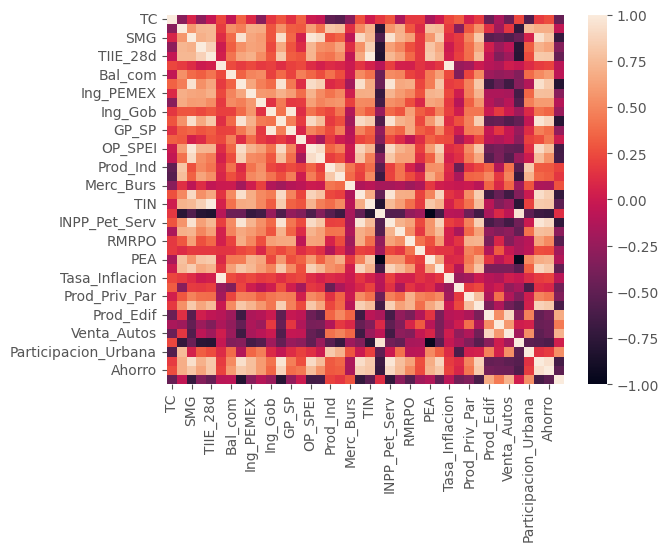

In [ ]:
sns.heatmap(variables_macro_transformadas.corr())

El análisis de la matriz de correlación muestra cómo distintos factores económicos se relacionan entre sí.
El PIB tiene una fuerte conexión con las remesas, las exportaciones y el consumo, lo que indica que el crecimiento económico depende de la entrada de divisas y la demanda interna. La correlación negativa entre el tipo de cambio y el PIB sugiere que la depreciación del peso no siempre impulsa la economía, posiblemente por el encarecimiento de insumos dolarizados y su efecto en la inflación.

El desempleo, la subocupación y la informalidad están fuertemente ligados, reflejando que, en tiempos de crisis, más personas entran en el sector informal por falta de empleo formal. En el sector energético, los ingresos de PEMEX y las exportaciones petroleras muestran una fuerte relación, confirmando la dependencia de la economía en los hidrocarburos.

Finalmente, la bolsa de valores (IPC) y las tasas de interés (TIIE) están correlacionadas, lo que indica que el mercado financiero responde a la política monetaria. En conjunto, estos datos sugieren que el crecimiento económico depende del comercio exterior y el consumo, pero enfrenta riesgos por la inflación, el tipo de cambio y la precarización laboral.

**Hay que resaltar que existen casos donde la correlación de las variables es fuerte, ya sea de manera positiva (círculos azules) o negativa (círculos rojos), lo cual puede convertirse en un problema para llevar a cabo la
regresión. Se van a eliminar algunas que pueden estar aportando información similar.**

* Desocupación Urbana: Ya se está considerando la Población Económicamente Activa (PEA) y la
Población Desocupada (Pob_Desocupada)
* Ing_PEMEX: Se tiene otra variable que ya cuenta con los datos sobre el ingreso por explotación y
distribución de hidrocarburos (FMP_AT)
* IGAE_2018 y INPP_Pet_Serv: El PIB aporta información similar sobre la actividad económica.
* TIIE_28d: Aparecen otras tasas como la de Interés Nominal (TIN) o la de Crédito a los hogares
(TICH).
* CC_VigP: Es más para créditos al sector privados como empresas grandes.
* GP_SP: Hay otra variable que considera tanto ingresos como gastos del Sector Público (Ing_Gob).
* Exp_Total y Res_Inter: Son indicadores que son más útiles para analizar situaciones externas.
* OP_SPEI: Aunque refleja la actividad financiera por el número de operaciones, existen otras variables
que se relacionan más con las razones del impago en las tarjetas de crédito.

In [ ]:
variables_correlacionadas = ["Desocupacion_Urbana","Res_Inter","Ing_PEMEX","IGAE_2018",
"TIIE_28d","CC_VigP","GP_SP","INPP_Pet_Serv","OP_SPEI","Exp_Total"]
variables_modelo = variables_macro_transformadas.drop(variables_correlacionadas,axis="columns")
variables_modelo.head()

,TC,SMG,TICH,INPC_OGN,Bal_com,Deuda_Pub,IPC,Ing_Gob,FMP_AT,Prod_Ind,...,Des_Sub,Prod_Priv_Par,May_Text_Calz,Prod_Edif,Rem_Manu,Venta_Autos,Participacion_Urbana,PIB,Ahorro,Tasa_Informalidad
0,-2.505133,-1.067176,0.196202,-1.290090,-0.438307,-1.624656,-1.266931,-1.596118,-1.607491,-0.844812,...,-0.725491,-1.174203,-1.818729,0.220244,1.199532,0.580363,-0.079680,-1.698918,-2.447647,1.371158
1,-2.371942,-1.067176,-0.116332,-0.527475,-0.254490,-1.626726,-0.626837,-1.424755,-1.607532,-0.854483,...,0.159351,-1.328591,-1.817423,0.622482,0.405030,0.384248,0.175451,-1.749137,-2.384362,1.293662
2,-2.193151,-1.067176,-0.137168,0.071722,-0.108216,-1.622237,-0.718791,-1.155214,-1.607521,0.169980,...,-0.802086,-0.882821,-1.625001,1.016629,0.356048,0.543338,0.295541,-1.799804,-2.321735,1.216165
3,-2.194374,-1.051294,-0.137168,-1.753106,-0.545990,-1.626875,-0.549341,-0.958802,-1.607493,-0.178305,...,-0.314409,-0.735626,-1.604074,0.601790,0.443700,0.269304,0.094950,-1.728500,-2.143186,1.268917
4,-2.172069,-1.051294,-0.991429,-2.406776,0.012173,-1.582616,-0.525388,-0.780263,-1.607371,-0.073490,...,-0.360381,0.787169,-0.512750,0.798964,0.627528,0.463187,0.244311,-1.658081,-1.969783,1.321668


In [ ]:
variables_modelo.corr()

,TC,SMG,TICH,INPC_OGN,Bal_com,Deuda_Pub,IPC,Ing_Gob,FMP_AT,Prod_Ind,...,Des_Sub,Prod_Priv_Par,May_Text_Calz,Prod_Edif,Rem_Manu,Venta_Autos,Participacion_Urbana,PIB,Ahorro,Tasa_Informalidad
TC,1.000000,0.064642,-0.283669,0.232273,-0.048503,0.339971,-0.316389,0.160354,0.331956,-0.507202,...,0.313200,0.034455,0.173915,-0.456235,-0.159667,-0.451785,-0.577453,0.185195,0.255254,-0.476248
SMG,0.064642,1.000000,0.694257,0.109980,0.375783,0.948086,0.600605,0.288484,0.038088,0.267699,...,0.184471,0.478059,0.815743,-0.539834,-0.485566,-0.573866,0.051017,0.935979,0.801079,-0.711261
TICH,-0.283669,0.694257,1.000000,0.007503,0.326497,0.540858,0.606430,0.237988,0.102921,0.502888,...,0.168374,0.392898,0.645050,0.024697,-0.224748,-0.072602,0.325102,0.698925,0.636902,-0.332189
INPC_OGN,0.232273,0.109980,0.007503,1.000000,0.249032,0.180950,0.174731,0.202243,0.240850,0.102550,...,-0.234593,-0.189729,-0.005543,-0.098075,-0.142217,0.016929,0.108059,0.183145,0.216623,-0.083476
Bal_com,-0.048503,0.375783,0.326497,0.249032,1.000000,0.341885,0.515980,0.209894,0.465878,0.403550,...,-0.346424,0.224360,0.509375,-0.216624,-0.270565,-0.231053,0.375437,0.514949,0.591619,-0.070810
Deuda_Pub,0.339971,0.948086,0.540858,0.180950,0.341885,1.000000,0.462790,0.375547,0.114541,0.098266,...,0.224595,0.469687,0.807526,-0.662486,-0.481722,-0.665751,-0.119033,0.935212,0.821046,-0.810848
IPC,-0.316389,0.600605,0.606430,0.174731,0.515980,0.462790,1.000000,0.132894,0.183084,0.544917,...,-0.100163,0.329064,0.577284,-0.107834,-0.219598,-0.089286,0.465345,0.593587,0.588445,-0.106657
Ing_Gob,0.160354,0.288484,0.237988,0.202243,0.209894,0.375547,0.132894,1.000000,0.111948,0.230689,...,0.017252,0.423228,0.427232,-0.001944,0.176389,-0.005028,0.098618,0.411208,0.351948,-0.233180
FMP_AT,0.331956,0.038088,0.102921,0.240850,0.465878,0.114541,0.183084,0.111948,1.000000,0.184274,...,-0.180711,0.037720,0.244175,-0.063533,-0.131908,-0.053110,0.207356,0.261540,0.431151,0.006548
Prod_Ind,-0.507202,0.267699,0.502888,0.102550,0.403550,0.098266,0.544917,0.230689,0.184274,1.000000,...,-0.465866,0.135465,0.232804,0.345901,-0.123439,0.399366,0.823291,0.309641,0.298540,0.216479


<Axes: >

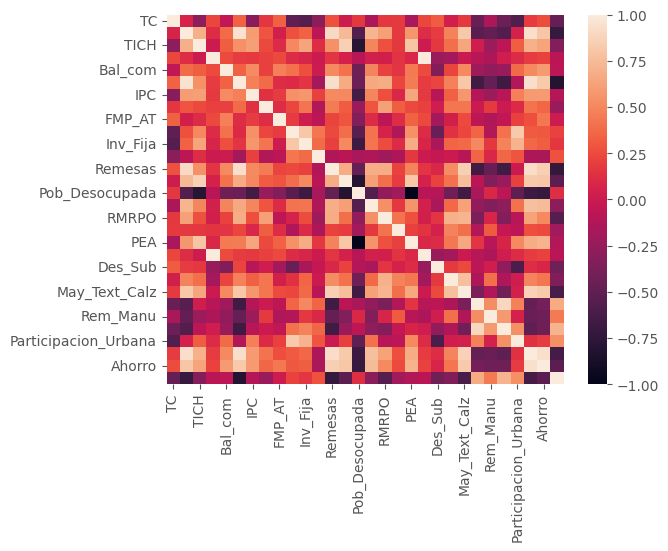

In [ ]:
sns.heatmap(variables_modelo.corr())

Con la eliminación de variables altamente correlacionadas, la matriz de correlación muestra una imagen más clara de las relaciones económicas sin redundancias. Se observa que la inflación y el tipo de cambio tienen una
relación significativa, lo que indica que las variaciones en la moneda pueden impactar los precios de bienes y servicios. La deuda pública y el salario mínimo general (SMG) también están fuertemente relacionadas,
sugiriendo que el financiamiento gubernamental podría influir en políticas salariales.

El PIB sigue correlacionado con las remesas y el consumo, lo que confirma que la economía depende de la entrada de dinero del exterior y del gasto interno. Además, la inversión fija y la participación urbana muestran una fuerte relación con la producción industrial, lo que es consistente con el hecho de que la urbanización impulsa la infraestructura y la actividad manufacturera.

Por otro lado, la tasa de informalidad y el desempleo parcial (subocupación) siguen estando correlacionados, lo que refleja que en condiciones económicas adversas, el mercado laboral se precariza. Finalmente, la relación entre el mercado bursátil y la producción manufacturera sugiere que la estabilidad industrial puede influir en el desempeño financiero.

Este análisis ajustado muestra cómo la actividad económica depende de flujos externos, inversión y estabilidad financiera, al tiempo que enfrenta riesgos por inflación, precarización laboral y volatilidad en el tipo de
cambio.

# $\textbf{TOTAL DE LA BANCA MÚLTIPLE: TBM}$

In [485]:
TBM_Score=pd.DataFrame(data=np.log((PD_bancos/100)/(1-PD_bancos/100)),columns=["TBM"])
TBM_Score

TBM_Score.head()

,TBM
0,-1.617414
1,-1.603144
2,-1.596043
3,-1.590041
4,-1.593463


In [486]:
significativas=["TC","SMG","Deuda_Pub","Ing_Gob","ICC","TICH","TIN","Participacion_Urbana","Prod_Edif"]
predictoras=sm.add_constant(variables_modelo[significativas])  # B0
TBM_reg_mult= sm.OLS(TBM_Score,predictoras)
# variable y, variables predictoras
TBM_reg_mult = TBM_reg_mult.fit()
print(TBM_reg_mult.summary())

                            OLS Regression Results                            
Dep. Variable:                    TBM   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     82.20
Date:                Mon, 24 Mar 2025   Prob (F-statistic):           1.11e-44
Time:                        04:40:59   Log-Likelihood:                 131.97
No. Observations:                 120   AIC:                            -243.9
Df Residuals:                     110   BIC:                            -216.1
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.7975 

In [487]:
comparacion = pd.DataFrame()
comparacion= comparacion.assign(PD_TBM =PD_bancos["TBM"] / 100,Score_TBM=TBM_Score,
                                Score_Predicho = TBM_reg_mult.predict())
comparacion = comparacion.assign(PD_Predicha=1/(1+np.exp(-1*comparacion["Score_Predicho"])))
comparacion

,PD_TBM,Score_TBM,Score_Predicho,PD_Predicha
0,0.165562,-1.617414,-1.541646,0.176296
1,0.167543,-1.603144,-1.569493,0.172289
2,0.168535,-1.596043,-1.555297,0.174323
3,0.169378,-1.590041,-1.639611,0.162518
4,0.168897,-1.593463,-1.648853,0.161264
...,...,...,...,...
115,0.124141,-1.953787,-2.016181,0.117514
116,0.125722,-1.939322,-1.930499,0.126695
117,0.126361,-1.933523,-1.986642,0.120613
118,0.120046,-1.991997,-2.085400,0.110524


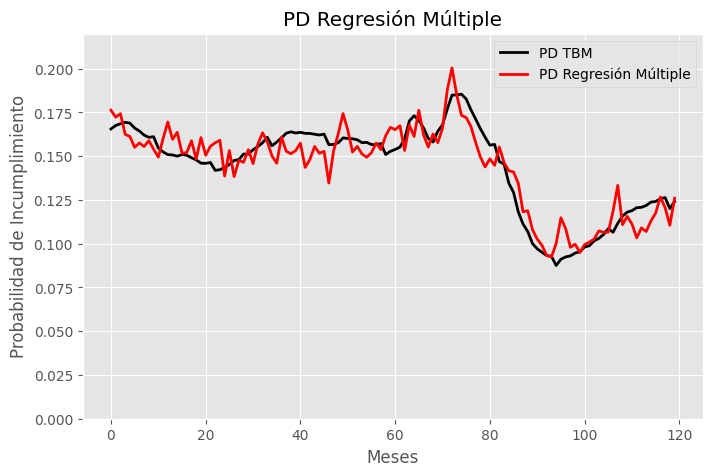

In [488]:
# Gráfica
plt.figure(figsize=(8, 5))
plt.plot(comparacion["PD_TBM"], label="PD TBM", linewidth=2, color='black')
plt.plot(comparacion['PD_Predicha'], label="PD Regresión Múltiple", linewidth=2, color='red')

# Agregar etiquetas y título
plt.ylim(0, 0.22)
plt.title("PD Regresión Múltiple")
plt.xlabel("Meses")
plt.ylabel("Probabilidad de Incumplimiento")

# Agregar leyenda
plt.legend(loc='upper right', fontsize=10)

# Mostrar la gráfica
plt.show()

## **SUPUESTOS**

Lo que se va a hacer es un Análisis de Varianza ANOVA para el modelo de regresión múltiple, así como la verificación de los 4 supuestos para los errores a través del valor p y de los estadísticos de las pruebas
adecuadas para cada uno.
* Media Cero: Calcular la media
* Normalidad: Prueba de Anderson Darling
* Independencia: Prueba de Durbin Watson
* Varianza Constante: Prueba de Breusch Pagan

Al final se van a comparar los modelos que presentan penalización y también se dará una interpretación de
lo que representan las variables ante el planteamiento de que las personas dejen de pagar sus tarjetas de
crédito.

In [ ]:
print(f"Media de los residuales: {TBM_reg_mult.resid.mean()}")


Media de los residuales: -7.75305745529901e-16


Estadístico de Anderson-Darling: 0.5053020363309884
Valores críticos: [0.558 0.636 0.763 0.89  1.059]
Niveles de significancia: [15.  10.   5.   2.5  1. ]


(array([ 1.,  2.,  4., 12., 18., 22., 20., 27., 10.,  4.]),
 array([-0.25737367, -0.21401019, -0.17064671, -0.12728323, -0.08391976,
        -0.04055628,  0.0028072 ,  0.04617068,  0.08953416,  0.13289763,
         0.17626111]),
 <BarContainer object of 10 artists>)

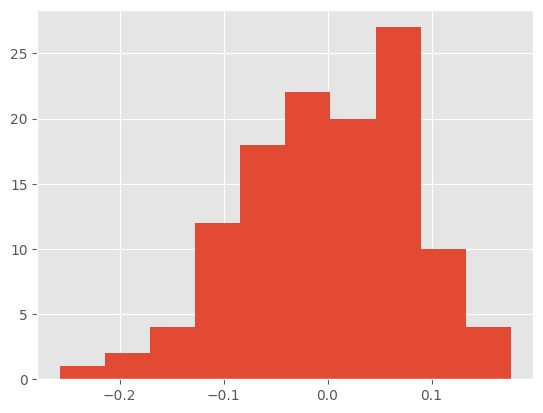

In [ ]:
# Prueba de Anderson Darling
ad_test = anderson(TBM_reg_mult.resid)

# Mostrar los resultados
print("Estadístico de Anderson-Darling:", ad_test.statistic)
print("Valores críticos:", ad_test.critical_values)
print("Niveles de significancia:", ad_test.significance_level)

plt.hist(TBM_reg_mult.resid)  # HISTOGRAMA

In [ ]:
# Prueba de Durbin-Watson
dw_statistic = durbin_watson(TBM_reg_mult.resid)

print(f"Durbin-Watson statistic: {dw_statistic}")

Durbin-Watson statistic: 0.7798328240541011


In [ ]:
bp_test = het_breuschpagan(TBM_reg_mult.resid, TBM_reg_mult.model.exog)
print("Breusch-Pagan Test:")
print(f"Estadístico BP: {bp_test[0]}")
print(f"P-valor: {bp_test[1]}")

Breusch-Pagan Test:
Estadístico BP: 9.690915907662285
P-valor: 0.3760818417624661


## **ANOVA**

In [ ]:
# Lista de variables predictoras
significativas = ["TC", "SMG", "Deuda_Pub", "Ing_Gob", "ICC", "TICH", "TIN", "Participacion_Urbana", "Prod_Edif"]

# Ajustar el modelo correctamente con ols()
formula = "TBM_Score ~ " + " + ".join(significativas)
TBM_reg_mult = ols(formula, data=variables_modelo).fit()

# Aplicar ANOVA correctamente
anova_results = anova_lm(TBM_reg_mult, typ=2)  # ANOVA tipo II (el más usado en regresión múltiple)
print(anova_results)

                        sum_sq     df           F        PR(>F)
TC                    0.306761    1.0   43.324164  1.634410e-09
SMG                   1.082416    1.0  152.870740  1.534589e-22
Deuda_Pub             0.912992    1.0  128.942757  3.029643e-20
Ing_Gob               0.579712    1.0   81.873396  5.900836e-15
ICC                   0.194579    1.0   27.480590  7.741672e-07
TICH                  0.026885    1.0    3.796948  5.389314e-02
TIN                   0.281078    1.0   39.697001  6.283498e-09
Participacion_Urbana  0.472795    1.0   66.773378  5.677554e-13
Prod_Edif             0.648947    1.0   91.651503  3.719351e-16
Residual              0.778866  110.0         NaN           NaN


## **PENALIZACIÓN RIDGE**

In [489]:
# Definir las variables predictoras y la respuesta
X = variables_modelo.to_numpy() # Convertir a matriz
y = PD_bancos['TBM'] / 100 # Convertir a vector

# Calcular lambda_max
lambda_max = np.max(np.abs(X.T @ y)) / X.shape[0]

# Crear la secuencia logarítmica de 100 valores
lambda_seq = np.exp(np.linspace(np.log(lambda_max), np.log(lambda_max / 1000), 100))

# Configurar validación cruzada con 10 folds
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Validación cruzada para elegir el mejor lambda
ridge_cv = RidgeCV(alphas=lambda_seq,store_cv_values=True)
ridge_cv = ridge_cv.fit(X, y)

# Obtener el mejor lambda
lambda_optimo = round(ridge_cv.alpha_,8)
print("Mejor lambda:", lambda_optimo)


Mejor lambda: 0.01785124


In [491]:
# Ajustar Ridge con la mejor penalización
ridge = Ridge(alpha=lambda_optimo)
ridge= ridge.fit(X, y)

# Coeficientes del modelo Ridge
coeficientes = ridge.coef_
print("Coeficientes del modelo Ridge:", coeficientes)

# Predicciones con Ridge
y_pred_ridge = ridge.predict(X)
y_pred_ridge

Coeficientes del modelo Ridge: [-0.0164929  -0.08765749  0.01014278 -0.00027641 -0.00184301  0.0795984
 -0.00328662 -0.01215543 -0.00134572 -0.00104301  0.00100325 -0.00027062
  0.00501428 -0.02327414  0.00118748  0.00540814  0.0054811  -0.00134656
 -0.00118748 -0.00027641  0.00062243 -0.00344613  0.00812199  0.01869158
 -0.00432457 -0.00022072 -0.00747631 -0.00681086  0.01172197 -0.00218902]


array([0.1641896 , 0.16594814, 0.17083731, 0.16540699, 0.16703548,
       0.15200172, 0.16074466, 0.16549031, 0.16659297, 0.15926012,
       0.14951497, 0.15446202, 0.15586133, 0.1587315 , 0.16252112,
       0.15624489, 0.15387906, 0.15883181, 0.14826288, 0.15767243,
       0.14773801, 0.14880171, 0.1538442 , 0.14921178, 0.13373237,
       0.1492466 , 0.14493184, 0.15192977, 0.15090811, 0.15313857,
       0.15091182, 0.15764893, 0.16392743, 0.15685766, 0.14616242,
       0.13922012, 0.15103736, 0.14685968, 0.16126456, 0.16750939,
       0.16367877, 0.16105046, 0.15326709, 0.15774077, 0.15582928,
       0.15710885, 0.1480808 , 0.16194116, 0.15730104, 0.16485445,
       0.16283092, 0.15880824, 0.15293199, 0.15780159, 0.15366155,
       0.15658445, 0.15676402, 0.15482919, 0.15595677, 0.15438332,
       0.1585746 , 0.16085586, 0.1548111 , 0.17254911, 0.16076934,
       0.1841141 , 0.16256824, 0.1584837 , 0.15633272, 0.15410191,
       0.16572137, 0.17990886, 0.19262326, 0.18659944, 0.17797

In [492]:
# Comparación de valores reales vs predichos
comparacion = pd.DataFrame()

comparacion= comparacion.assign(PD_TBM =PD_bancos["TBM"] / 100,Score_TBM=TBM_Score,
                                PD_Ridge = y_pred_ridge)

comparacion = comparacion.assign(Score_Ridge=np.log((comparacion["PD_Ridge"]) / (1 - comparacion["PD_Ridge"])),
                                 Cuadrado_Errores=(comparacion["PD_TBM"] - comparacion["PD_Ridge"])**2,
                                 Cuadrado_Total=(comparacion["PD_TBM"]-np.mean(comparacion["PD_TBM"]))**2)

comparacion.head()

,PD_TBM,Score_TBM,PD_Ridge,Score_Ridge,Cuadrado_Errores,Cuadrado_Total
0,0.165562,-1.617414,0.164190,-1.627380,0.000002,0.000453
1,0.167543,-1.603144,0.165948,-1.614620,0.000003,0.000542
2,0.168535,-1.596043,0.170837,-1.579705,0.000005,0.000589
3,0.169378,-1.590041,0.165407,-1.618535,0.000016,0.000630
4,0.168897,-1.593463,0.167035,-1.606785,0.000003,0.000606


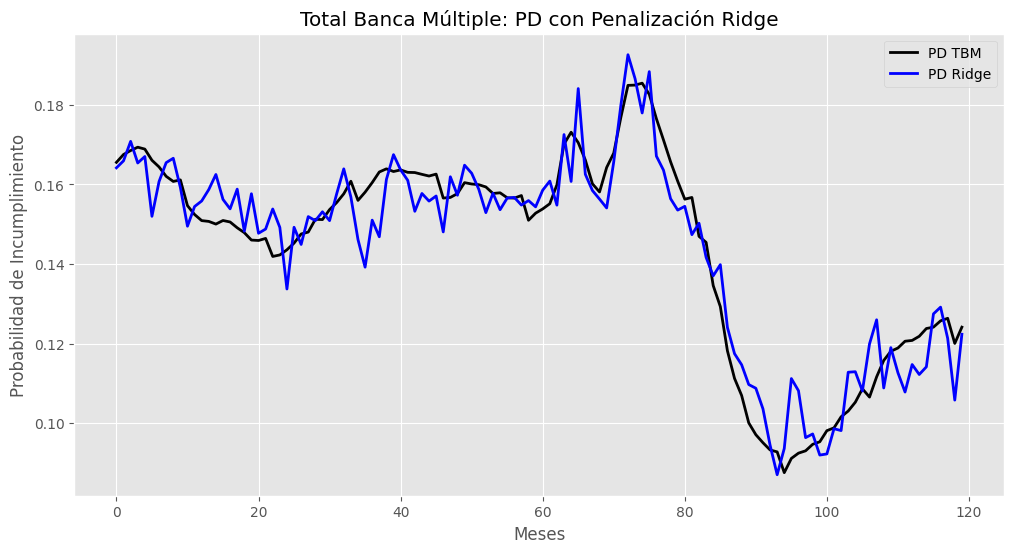

In [493]:
# Gráfico de la penalización Ridge
plt.figure(figsize=(12, 6))
plt.plot(comparacion["PD_TBM"], label="PD TBM", linewidth=2,color="black")
plt.plot(comparacion["PD_Ridge"], label="PD Ridge", linewidth=2, color="blue")
plt.title("Total Banca Múltiple: PD con Penalización Ridge")
plt.xlabel("Meses")
plt.ylabel("Probabilidad de Incumplimiento")
plt.legend()
plt.show()

In [ ]:
# Función que calcula el R^2 ajustado
def adj_r_cuadrado(df):
  numerador=np.sum(df["Cuadrado_Errores"])/(120 - variables_modelo.shape[1]-1)
  denominador=np.sum(df["Cuadrado_Total"]) / (120-1)
  return(1-(numerador / denominador))
print("El coeficiente de determinación R^2 ajustado es: ",adj_r_cuadrado(comparacion),"\n")

# Métricas
MAE_Ridge=np.mean(abs(comparacion["PD_TBM"] - comparacion["PD_Ridge"]))
MSE_Ridge=np.mean((comparacion["PD_TBM"] - comparacion["PD_Ridge"])**2)
RMSE_Ridge=np.sqrt(MSE_Ridge)
MAPE_Ridge=np.mean(abs((comparacion["PD_TBM"] - comparacion["PD_Ridge"]) / comparacion["PD_TBM"])) * 100

# Mostrar resultados
print("MAE Ridge:", MAE_Ridge, "\n")
print("MSE Ridge:", MSE_Ridge, "\n")
print("RMSE Ridge:", RMSE_Ridge, "\n")
print("MAPE Ridge:", MAPE_Ridge,"%\n")

El coeficiente de determinación R^2 ajustado es:  0.8930853585889607 

MAE Ridge: 0.005769919803089277 

MSE Ridge: 5.173990772887578e-05 

RMSE Ridge: 0.00719304578943272 

MAPE Ridge: 4.284623608476159 %



## **PENALIZACIÓN LASSO**

In [545]:
# Validación cruzada para elegir el mejor lambda
lasso_cv = LassoCV(alphas=lambda_seq,cv=10,max_iter=10000)  # Validación cruzada
lasso_cv = lasso_cv.fit(X, y)
lambda_optimo = lasso_cv.alpha_
print("Mejor lambda para Lasso:",lambda_optimo)

Mejor lambda para Lasso: 0.5645664380029708


In [546]:
# Ajustar Lasso con la mejor penalización
lasso = Lasso(alpha=lambda_optimo,max_iter=10000)
lasso=lasso.fit(X, y)

# Coeficientes del modelo Lasso
coeficientes = lasso.coef_
print("Coeficientes del modelo Lasso:", coeficientes)

# Predicciones con Lasso
y_pred_lasso = lasso.predict(X)
y_pred_lasso

Coeficientes del modelo Lasso: [-0.00000000e+00 -3.30499928e-01 -0.00000000e+00 -0.00000000e+00
 -1.09756860e-01 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -1.11301887e-01 -2.27738209e-01  1.39966671e-01 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -3.24222442e-13 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00]


array([14.45562451, 14.34924002, 14.16396372, 14.3465214 , 14.27483923,
       14.32731195, 14.36594575, 14.39490092, 14.41906324, 14.39554486,
       14.34325336, 14.36984693, 14.46340241, 14.37987257, 14.22841156,
       14.24428705, 14.164477  , 14.17267573, 14.15106277, 14.11023036,
       14.09183442, 13.97130849, 13.92649319, 13.79853109, 13.84996092,
       13.76294741, 13.69516473, 13.76793972, 13.75278557, 13.67983694,
       13.64991951, 13.67901632, 13.68986408, 13.55612603, 13.54567588,
       13.32474965, 13.54813479, 13.43521016, 13.36520814, 13.41731756,
       13.31087823, 13.38121492, 13.37635839, 13.37578787, 13.38610953,
       13.327904  , 13.37030942, 13.36071919, 13.4337653 , 13.27175671,
       13.23794318, 13.33999411, 13.23814514, 13.36782873, 13.35532026,
       13.40386857, 13.4691712 , 13.48154813, 13.43362626, 13.27410249,
       13.41437955, 13.48775646, 13.30607642, 13.88281526, 13.73874233,
       13.94613433, 13.92146296, 13.86449271, 13.90048414, 13.86

In [547]:
# Comparación de valores reales vs predichos
comparacion = pd.DataFrame()

comparacion= comparacion.assign(PD_TBM =PD_bancos["TBM"] / 100,Score_TBM=TBM_Score,
                                PD_Lasso = y_pred_lasso / 100)
comparacion = comparacion.assign(Score_Lasso=np.log((comparacion["PD_Lasso"]) / (1 - comparacion["PD_Lasso"])))
comparacion.head()

,PD_TBM,Score_TBM,PD_Lasso,Score_Lasso
0,0.165562,-1.617414,0.144556,-1.777952
1,0.167543,-1.603144,0.143492,-1.786581
2,0.168535,-1.596043,0.141640,-1.801738
3,0.169378,-1.590041,0.143465,-1.786802
4,0.168897,-1.593463,0.142748,-1.792648


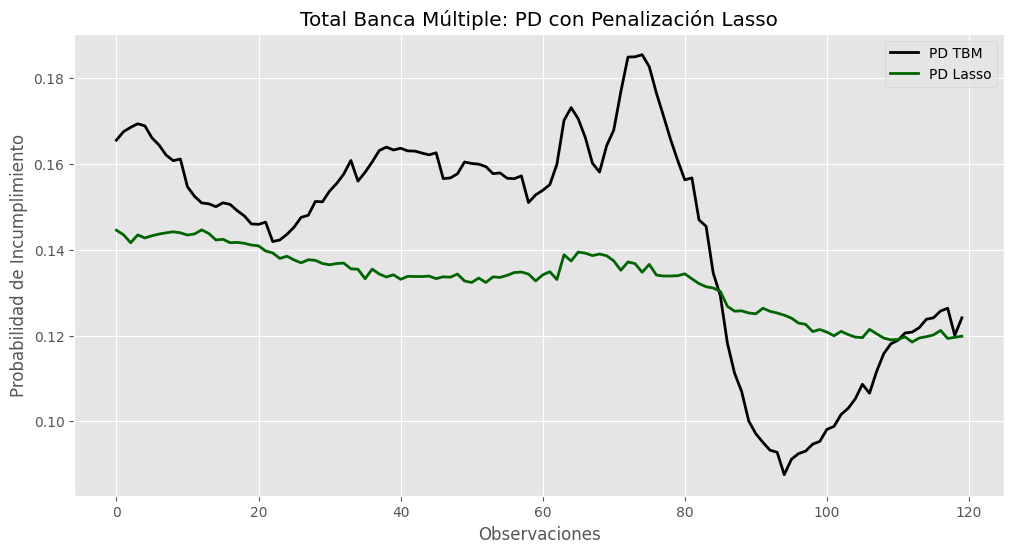

In [548]:
# Gráfico de la penalización Lasso
plt.figure(figsize=(12, 6))
plt.plot(comparacion["PD_TBM"], label="PD TBM", linewidth=2,color="black")
plt.plot(comparacion["PD_Lasso"], label="PD Lasso", linewidth=2, color="darkgreen")
plt.title("Total Banca Múltiple: PD con Penalización Lasso")
plt.xlabel("Observaciones")
plt.ylabel("Probabilidad de Incumplimiento")
plt.legend()
plt.show()

# $\textbf{INTERPRETACIÓN}$

El modelo de regresión múltiple explica alrededor de un 86% de la variabilidad de la variable dependiente (score) reflejado en el valor del r cuadrado ajustado, debido a que si es un porcentaje alto significa que
ajusta bien al comportamiento que se quiere predecir.

Lo siguiente que se verificó fueron los supuestos de un modelo de regresión, vemos que cumple que la media de los errores sea cero, también que la varianza es constante y que los errores presentan un comportamiento
normal (debido a que en ambos casos se tiene un valor-p mayor al nivel de significancia provocando que no se rechacen las hipótesis nulas). Lo único que hay que recalcar es que hay problemas con el Supuesto de la Autocorrelación, pues el valor del estadístico en la prueba Durbin Watsson es 0.779, el cual nos indica que hay autocorrelación positiva entre los residuales en lugar de que sean completamente independientes, lo cual es un punto a tener en consideración.

Por otro lado, se realizaró el modelo  que tienen penalización Ridge aquí en Python y  también sus métricas obtenidas tienen resultados más eficientes en cuanto al error comparadas con el de la regresión pura. De igual manera, en la gráfica correspondiente se ve que para este modelo las líneas de la Probilidad de Incumplimiento y las Predicciones siguen la misma trayectoria y la distancia de separación es menor.

Finalmente, se presentan las variables que resultaron ser significativas dentro del modelo de regresión múltiple y el sentido económico para el contexto del problema, es decir, la relación que tienen con la Probabilidad de
Incumplimiento de las Tarjetas de Crédito tomando en cuenta los datos del Total de la Banca Múltiple:

* TC: El Tipo de Cambio puede ser relevante debido a que si sufre movimientos importantes impacta en
la depreciación del peso y también en el precio de los bienes, al mismo tiempo que el poder adquisitivo
disminuye y que si hay una deuda en dólares se aumenta la carga financiera, es por esta razón que es
una de las variables a monitorear al analizar el incumplimiento del pago en las tarjetas.
* SMG: Considerar el Salario Mínimo General como variable de predicción es importante ya que está
relacionado directamente con el ingreso que una persona recibe, si hay una reducción puede limitar su
capacidad de pago y llevar a una probabilidad de incumplimiento más grande.
* ICC: Este valor del Indicador de Confianza del Consumidor refleja si las personas priorizan su ahorro
o de cierta forma prefieren usar el crédito y haciendo los pagos correspondientes, por lo que se puede
decir que a mayor confianza del consumidor, es menos probable que lleguen a un impago.
* Deuda_Pub: Si hay déficit fiscal o deuda se afecta a toda la economía en general y como medida
de respuesta el gobierno puede recortar los gastos e incrementar los impuestos afectando los ingresos
disponibles de todos.
* Ing_Gob: Abarca el ingreso-gasto que tiene el gobierno, así que si cuenta con recursos los puede
distribuir mediante subsidios o apoyos sociales incrementando el ingreso que tienen las personas, por
lo que un impago en las tarejtas sería menos probable.
* TIN: Se trata de la tasa de interés para los instrumentos de deuda en el corto plazo, entonces si llega
a subir recae en un costo mayor de financiamiento para los bancos ocasionando que a su vez aumenten
la tasa del crédito. Además, este rubro puede considerarse como una tasa de referencia de la que
dependen o están basadas las tarjetas de crédito. Por lo tanto, la relación sería que si se incrementan
los valores de este indicador, puede generar mayor cantidad de impagos.
* Participación_Urbana: Hace referencia al porcentaje de la población en edad de trabajar que
participa en el mercado laboral en áreas urbanas, de este modo, un mayor porcentaje participación
indica que las personas tienen más disponibilidad de los ingresos porque tienen trabajo o lo están
buscando activamente, es decir, hay dinamismo económico, lo que reduce el incumplimiento de los
pagos.
* Prod_Edif: Esta variable tiene que ver con el valor económico generado por el sector de la construcción
en actividades de edificación y la manera en que puede estar relacionada con el impago en
las tarjetas de crédito es que si disminuye considerablemente indicaría que se atraviesa un periodo de
inestabilidad económica donde hay desempleo provocando que los pagos no se lleven a cabo.

# $\textbf{BANORTE}$

In [494]:
Banorte_Score=pd.DataFrame(data=np.log((PD_bancos/100)/(1-PD_bancos/100)),columns=["Banorte"])
Banorte_Score

,Banorte
0,-1.710342
1,-1.692185
2,-1.667429
3,-1.652220
4,-1.641209
...,...
115,-2.046314
116,-2.047988
117,-2.049219
118,-2.095315


In [495]:
significativas=["TC","SMG","Bal_com","Deuda_Pub","Ing_Gob","ICC","RMRPO","TIN","Participacion_Urbana","Prod_Edif","Rem_Manu",
                "Remesas","Ahorro"]
predictoras=sm.add_constant(variables_modelo[significativas])  # B0
Banorte_reg_mult= sm.OLS(Banorte_Score,predictoras)
# variable y, variables predictoras
Banorte_reg_mult = Banorte_reg_mult.fit()
print(Banorte_reg_mult.summary())

                            OLS Regression Results                            
Dep. Variable:                Banorte   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     114.5
Date:                Mon, 24 Mar 2025   Prob (F-statistic):           4.00e-56
Time:                        04:41:41   Log-Likelihood:                 158.31
No. Observations:                 120   AIC:                            -288.6
Df Residuals:                     106   BIC:                            -249.6
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.7600 

In [496]:
comparacion = pd.DataFrame()
comparacion= comparacion.assign(PD_Banorte =PD_bancos["Banorte"] / 100,Score_Banorte=Banorte_Score,
                                Score_Predicho = Banorte_reg_mult.predict())
comparacion = comparacion.assign(PD_Predicha=1/(1+np.exp(-1*comparacion["Score_Predicho"])))
comparacion

,PD_Banorte,Score_Banorte,Score_Predicho,PD_Predicha
0,0.153119,-1.710342,-1.776132,0.144781
1,0.155489,-1.692185,-1.711215,0.153006
2,0.158767,-1.667429,-1.633368,0.163370
3,0.160809,-1.652220,-1.694445,0.155192
4,0.162301,-1.641209,-1.622615,0.164844
...,...,...,...,...
115,0.114425,-2.046314,-2.013478,0.117795
116,0.114256,-2.047988,-1.999143,0.119293
117,0.114131,-2.049219,-2.072786,0.111770
118,0.109553,-2.095315,-2.213007,0.098588


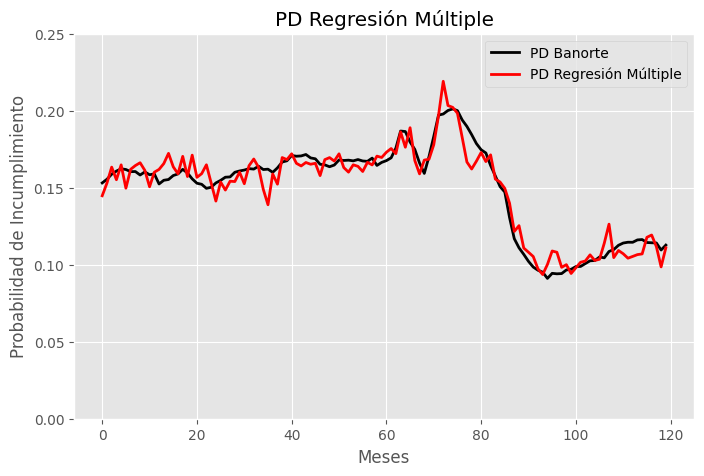

In [497]:
# Gráfica
plt.figure(figsize=(8, 5))
plt.plot(comparacion["PD_Banorte"], label="PD Banorte", linewidth=2, color='black')
plt.plot(comparacion['PD_Predicha'], label="PD Regresión Múltiple", linewidth=2, color='red')

# Agregar etiquetas y título
plt.ylim(0, 0.25)
plt.title("PD Regresión Múltiple")
plt.xlabel("Meses")
plt.ylabel("Probabilidad de Incumplimiento")

# Agregar leyenda
plt.legend(loc='upper right', fontsize=10)

# Mostrar la gráfica
plt.show()

## **SUPUESTOS**

Lo que se va a hacer es un Análisis de Varianza ANOVA para el modelo de regresión múltiple, así como la verificación de los 4 supuestos para los errores a través del valor p y de los estadísticos de las pruebas
adecuadas para cada uno.
* Media Cero: Calcular la media
* Normalidad: Prueba de Anderson Darling
* Independencia: Prueba de Durbin Watson
* Varianza Constante: Prueba de Breusch Pagan

Al final se van a comparar los modelos que presentan penalización y también se dará una interpretación de
lo que representan las variables ante el planteamiento de que las personas dejen de pagar sus tarjetas de
crédito.

In [ ]:
print(f"Media de los residuales: {Banorte_reg_mult.resid.mean()}")


Media de los residuales: 4.903485025427775e-16


Estadístico de Anderson-Darling: 0.361801822240551
Valores críticos: [0.558 0.636 0.763 0.89  1.059]
Niveles de significancia: [15.  10.   5.   2.5  1. ]


(array([ 4.,  5.,  5., 21., 27., 29., 16.,  9.,  1.,  3.]),
 array([-0.17144721, -0.13620598, -0.10096475, -0.06572352, -0.03048228,
         0.00475895,  0.04000018,  0.07524141,  0.11048265,  0.14572388,
         0.18096511]),
 <BarContainer object of 10 artists>)

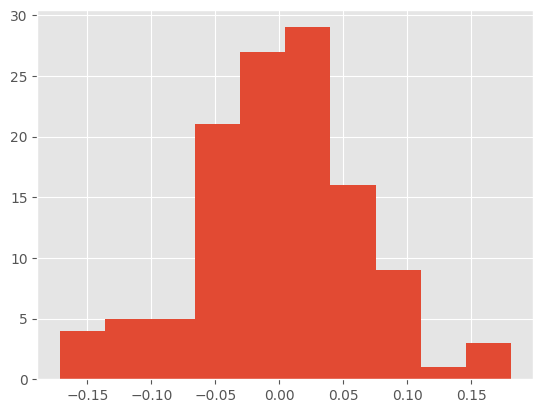

In [ ]:
# Prueba de Anderson Darling
ad_test = anderson(Banorte_reg_mult.resid)

# Mostrar los resultados
print("Estadístico de Anderson-Darling:", ad_test.statistic)
print("Valores críticos:", ad_test.critical_values)
print("Niveles de significancia:", ad_test.significance_level)

plt.hist(Banorte_reg_mult.resid)  # HISTOGRAMA

In [ ]:
# Prueba de Durbin-Watson
dw_statistic = durbin_watson(Banorte_reg_mult.resid)

print(f"Durbin-Watson statistic: {dw_statistic}")

Durbin-Watson statistic: 1.0883218945704345


In [ ]:
bp_test = het_breuschpagan(Banorte_reg_mult.resid, Banorte_reg_mult.model.exog)
print("Breusch-Pagan Test:")
print(f"Estadístico BP: {bp_test[0]}")
print(f"P-valor: {bp_test[1]}")

Breusch-Pagan Test:
Estadístico BP: 13.022990940674948
P-valor: 0.4460373565616091


## **ANOVA**

In [ ]:
# Lista de variables predictoras
significativas = ["TC","SMG","Bal_com","Deuda_Pub","Ing_Gob","ICC","RMRPO","TIN","Participacion_Urbana","Prod_Edif","Rem_Manu",
                "Remesas","Ahorro"]

# Ajustar el modelo correctamente con ols()
formula = "Banorte_Score ~ " + " + ".join(significativas)
Banorte_reg_mult = ols(formula, data=variables_modelo).fit()

# Aplicar ANOVA correctamente
anova_results = anova_lm(Banorte_reg_mult, typ=2)  # ANOVA tipo II (el más usado en regresión múltiple)
print(anova_results)

                        sum_sq     df           F        PR(>F)
TC                    0.332367    1.0   67.937871  4.860250e-13
SMG                   1.258880    1.0  257.322987  4.047782e-30
Bal_com               0.058268    1.0   11.910441  8.027343e-04
Deuda_Pub             0.728795    1.0  148.970299  6.300915e-22
Ing_Gob               0.594573    1.0  121.534446  2.746047e-19
ICC                   0.030954    1.0    6.327095  1.339122e-02
RMRPO                 0.077429    1.0   15.826907  1.272168e-04
TIN                   0.414994    1.0   84.827342  3.362670e-15
Participacion_Urbana  0.285590    1.0   58.376312  1.018058e-11
Prod_Edif             0.399174    1.0   81.593786  8.406168e-15
Rem_Manu              0.085463    1.0   17.469160  6.022954e-05
Remesas               0.046240    1.0    9.451830  2.682696e-03
Ahorro                0.114983    1.0   23.503260  4.291407e-06
Residual              0.518575  106.0         NaN           NaN


## **PENALIZACIÓN RIDGE**

In [500]:
# Definir las variables predictoras y la respuesta
X = variables_modelo.to_numpy() # Convertir a matriz
y = PD_bancos['Banorte'] # Convertir a vector

# Calcular lambda_max
lambda_max = np.max(np.abs(X.T @ y)) / X.shape[0]

# Crear la secuencia logarítmica de 100 valores
lambda_seq = np.exp(np.linspace(np.log(lambda_max), np.log(lambda_max / 1000), 100))

# Configurar validación cruzada con 10 folds
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Validación cruzada para elegir el mejor lambda
ridge_cv = RidgeCV(alphas=lambda_seq,store_cv_values=True)
ridge_cv.fit(X, y)

# Obtener el mejor lambda
lambda_optimo = round(ridge_cv.alpha_,8)
print("Mejor lambda:", lambda_optimo)


Mejor lambda: 0.0381889


In [502]:
# Ajustar Ridge con la mejor penalización
ridge = Ridge(alpha=lambda_optimo)
ridge.fit(X, y)

# Coeficientes del modelo Ridge
coeficientes = ridge.coef_
print("Coeficientes del modelo Ridge:", coeficientes)

# Predicciones con Ridge
y_pred_ridge = ridge.predict(X)
y_pred_ridge

Coeficientes del modelo Ridge: [-1.41914069 -9.68151161  0.64578839 -0.02459122 -0.432715    6.68545675
 -0.04659158 -1.43379059 -0.1627315  -0.3668431   0.18935217 -0.11008196
  1.29709866 -2.72151914  0.07174463  0.47137319  0.59619428 -0.10918588
 -0.07174463 -0.02459122  0.04096858 -0.1751092   0.50790379  1.70064006
 -0.61676262  0.35868928 -0.89126956  0.89421219  1.45434629 -0.44117607]


array([15.02269195, 15.67039352, 16.24120144, 15.83946864, 16.36108288,
       14.84172854, 15.99632156, 16.50973341, 16.55961917, 15.8947675 ,
       15.03211701, 15.90744951, 15.97356439, 16.42541077, 16.70447912,
       16.29673716, 16.13647192, 16.93167705, 15.72697044, 16.479905  ,
       15.51096729, 15.30421801, 16.18615265, 15.6585201 , 14.27422733,
       15.44719693, 15.34447431, 16.06476522, 15.89449986, 16.19493552,
       15.837495  , 16.34071573, 16.6833168 , 15.95216036, 14.93163309,
       14.19643405, 15.71769675, 15.170056  , 16.81029242, 17.21505158,
       16.94628722, 17.11451685, 16.42422147, 16.6148175 , 16.5034707 ,
       16.43654748, 16.0533633 , 17.28877191, 16.79810535, 16.86883113,
       16.98201757, 16.6646972 , 15.90971809, 16.78445174, 16.33708108,
       16.3805554 , 16.50401675, 16.45608331, 16.8393426 , 16.81526443,
       16.80269887, 17.18600964, 16.79470558, 18.70700931, 17.84047102,
       18.89886171, 17.04416091, 16.48231613, 16.54604804, 16.47

In [503]:
# Comparación de valores reales vs predichos
comparacion = pd.DataFrame()

comparacion= comparacion.assign(PD_Banorte =PD_bancos["Banorte"] / 100,Score_Banorte=Banorte_Score,
                                PD_Ridge = y_pred_ridge / 100)

comparacion = comparacion.assign(Score_Ridge=np.log((comparacion["PD_Ridge"]) / (1 - comparacion["PD_Ridge"])),
                                 Cuadrado_Errores=(comparacion["PD_Banorte"] - comparacion["PD_Ridge"])**2,
                                 Cuadrado_Total=(comparacion["PD_Banorte"]-np.mean(comparacion["PD_Banorte"]))**2)

comparacion.head()

,PD_Banorte,Score_Banorte,PD_Ridge,Score_Ridge,Cuadrado_Errores,Cuadrado_Total
0,0.153119,-1.710342,0.150227,-1.732822,0.000008,0.000013
1,0.155489,-1.692185,0.156704,-1.682960,0.000001,0.000036
2,0.158767,-1.667429,0.162412,-1.640390,0.000013,0.000086
3,0.160809,-1.652220,0.158395,-1.670221,0.000006,0.000128
4,0.162301,-1.641209,0.163611,-1.631603,0.000002,0.000164


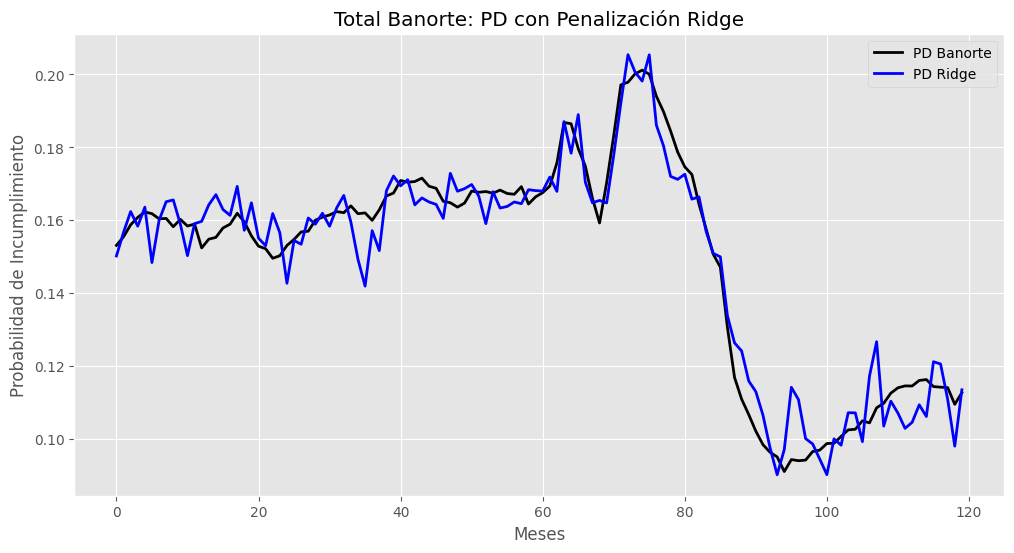

In [504]:
# Gráfico de la penalización Ridge
plt.figure(figsize=(12, 6))
plt.plot(comparacion["PD_Banorte"], label="PD Banorte", linewidth=2,color="black")
plt.plot(comparacion["PD_Ridge"], label="PD Ridge", linewidth=2, color="blue")
plt.title("Total Banorte: PD con Penalización Ridge")
plt.xlabel("Meses")
plt.ylabel("Probabilidad de Incumplimiento")
plt.legend()
plt.show()

In [505]:
# Función que calcula el R^2 ajustado
def adj_r_cuadrado(df):
  numerador=np.sum(df["Cuadrado_Errores"])/(120 - variables_modelo.shape[1]-1)
  denominador=np.sum(df["Cuadrado_Total"]) / (120-1)
  return(1-(numerador / denominador))
print("El coeficiente de determinación R^2 ajustado es: ",adj_r_cuadrado(comparacion),"\n")

# Métricas
MAE_Ridge=np.mean(abs(comparacion["PD_Banorte"] - comparacion["PD_Ridge"]))
MSE_Ridge=np.mean((comparacion["PD_Banorte"] - comparacion["PD_Ridge"])**2)
RMSE_Ridge=np.sqrt(MSE_Ridge)
MAPE_Ridge=np.mean(abs((comparacion["PD_Banorte"] - comparacion["PD_Ridge"]) / comparacion["PD_Banorte"])) * 100

# Mostrar resultados
print("MAE Ridge:", MAE_Ridge, "\n")
print("MSE Ridge:", MSE_Ridge, "\n")
print("RMSE Ridge:", RMSE_Ridge, "\n")
print("MAPE Ridge:", MAPE_Ridge,"%\n")

El coeficiente de determinación R^2 ajustado es:  0.9250934218185907 

MAE Ridge: 0.005527057924029111 

MSE Ridge: 4.879240419556886e-05 

RMSE Ridge: 0.006985155989351194 

MAPE Ridge: 4.059915922781957 %



# $\textbf{INTERPRETACIÓN}$

Es importante recalcar que eliminando las variables con colinealidad y las no significativas, el modelo logra predecir correctamente la variabilidad del score en un 92.5% aproximadamente (valor del r cuadrado
ajustado), al igual que el Criterio de Akaike AIC disminuye si se compara con el del modelo inicial que involucra más variables.

Se cumplen casi todos los supuestos de la regresión lineal para el modelo que tiene únicamente las variables significativas, solo la prueba falla en la Autocorrelación de los Residuales debido a que el estadístico de la prueba de Durbin Watson es cercano a 1 indicando la presencia de autocorrelación positiva como en el caso anterior. Para los otros supuestos si se cumple que la media de los residuales es cero, y también presentan varianza constante con un comportamiento significativamente normal pues el valor p muestra que
no se pueden rechazar estas hipótesis nulas.

Sobre los modelos con penalización, el de Ridge se acerca mucho con un r-cuadrado alto (igual del 0.92), y debido a que el porcentaje de
error es muy pequeño, se puede considerar como otra alternativa que funciona adecuadamente. Además de que en las dos
gráficas es posible observar que esos modelos son los que más se acercan a la línea de los datos de Banorte.

Por último, esta regresión comparte algunas variables significativas con las que se obtuvieron en Banca Múltiple, así que las que se repiten se pueden interpretar de manera similar y a continuación se presentan sólo las que aún no se han explicado en el contexto del planteamiento del problema, las cuales son:

* Bal_com: Abarca las exportaciones de petróleo, las cuales están ligadas a los ingresos del gobierno, el
empleo en este sector y al crecimiento económico, si disminuyen se dejan de fortalecer estos 3 factores
y llega a impactar la economía en general, por lo que existiría un incremento en el incumplimiento de
los pagos.
* RMRPO: Si el salario real cae por la inflación se cuenta con un poder adquisitivo real menor, por lo
que cubrir gastos básicos será la prioridad dejando de lado los pagos de la tarjeta de crédito cuando
haya periodos complicados.
* Rem_Manu: Refleja la evolución del salario en la industria manufacturera, el cual es un sector
importante en México. Si disminuye el salario real ocasionará que el endeudamiento que tengan las
personas sea insostenible aumentando así los impagos.
* Remesas: Debido a que es el dinero que reciben los hogares en México enviado por familiares en el
extranjero, si aumenta esta varible significa que las familias reciben un ingreso mayor, lo cual puede
volverse una causa para que la probabiliddad del impago en la tarjeta de crédito se reduzca.
* Ahorro: Este indicador del Ahorro Bruto indica si las empresas o personas cuentan con recursos
disponibles debido a que consumen menos de lo que ganan, entonces si un hogar tiene un nivel menor
de ahorro, cuando se presenten dificultades económicas puede dejar de pagar sus deudas para cubrir
solo sus necesidades básicas, provocando un incumplimiento en los pagos de sus tarjetas.

# $\textbf{BANAMEX}$

In [506]:
Banamex_Score=pd.DataFrame(data=np.log((PD_bancos/100)/(1-PD_bancos/100)),columns=["Banamex"])
Banamex_Score

,Banamex
0,-1.531407
1,-1.504377
2,-1.495362
3,-1.483758
4,-1.491818
...,...
115,-2.075341
116,-2.058350
117,-2.055413
118,-2.159493


In [507]:
significativas=["TC","SMG","Bal_com","Deuda_Pub","Ing_Gob","ICC","RMRPO","TICH","TIN","Prod_Edif","Rem_Manu"]
predictoras=sm.add_constant(variables_modelo[significativas])  # B0
Banamex_reg_mult= sm.OLS(Banamex_Score,predictoras)
# variable y, variables predictoras
Banamex_reg_mult = Banamex_reg_mult.fit()
print(Banamex_reg_mult.summary())

                            OLS Regression Results                            
Dep. Variable:                Banamex   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     88.31
Date:                Mon, 24 Mar 2025   Prob (F-statistic):           9.66e-49
Time:                        04:47:06   Log-Likelihood:                 103.85
No. Observations:                 120   AIC:                            -183.7
Df Residuals:                     108   BIC:                            -150.2
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.8266      0.010   -186.396      0.0

In [508]:
comparacion = pd.DataFrame()
comparacion= comparacion.assign(PD_Banamex =PD_bancos["Banamex"] / 100,Score_Banamex=Banamex_Score,
                                Score_Predicho = Banamex_reg_mult.predict())
comparacion = comparacion.assign(PD_Predicha=1/(1+np.exp(-1*comparacion["Score_Predicho"])))
comparacion

,PD_Banamex,Score_Banamex,Score_Predicho,PD_Predicha
0,0.177788,-1.531407,-1.600721,0.167881
1,0.181774,-1.504377,-1.560330,0.173599
2,0.183118,-1.495362,-1.507240,0.181348
3,0.184860,-1.483758,-1.537023,0.176968
4,0.183649,-1.491818,-1.529686,0.178040
...,...,...,...,...
115,0.111517,-2.075341,-2.089189,0.110152
116,0.113211,-2.058350,-2.093765,0.109704
117,0.113507,-2.055413,-2.126782,0.106521
118,0.103447,-2.159493,-2.303152,0.090862


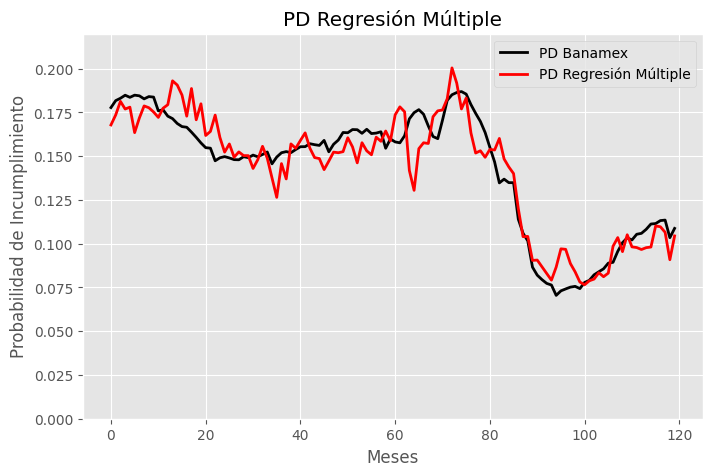

In [509]:
# Gráfica
plt.figure(figsize=(8, 5))
plt.plot(comparacion["PD_Banamex"], label="PD Banamex", linewidth=2, color='black')
plt.plot(comparacion['PD_Predicha'], label="PD Regresión Múltiple", linewidth=2, color='red')

# Agregar etiquetas y título
plt.ylim(0, 0.22)
plt.title("PD Regresión Múltiple")
plt.xlabel("Meses")
plt.ylabel("Probabilidad de Incumplimiento")

# Agregar leyenda
plt.legend(loc='upper right', fontsize=10)

# Mostrar la gráfica
plt.show()

## **SUPUESTOS**

Lo que se va a hacer es un Análisis de Varianza ANOVA para el modelo de regresión múltiple, así como la verificación de los 4 supuestos para los errores a través del valor p y de los estadísticos de las pruebas
adecuadas para cada uno.
* Media Cero: Calcular la media
* Normalidad: Prueba de Anderson Darling
* Independencia: Prueba de Durbin Watson
* Varianza Constante: Prueba de Breusch Pagan

Al final se van a comparar los modelos que presentan penalización y también se dará una interpretación de
lo que representan las variables ante el planteamiento de que las personas dejen de pagar sus tarjetas de
crédito.

In [ ]:
print(f"Media de los residuales: {Banamex_reg_mult.resid.mean()}")


Media de los residuales: 2.2759572004815707e-16


Estadístico de Anderson-Darling: 0.4663844181893495
Valores críticos: [0.558 0.636 0.763 0.89  1.059]
Niveles de significancia: [15.  10.   5.   2.5  1. ]


(array([ 2.,  4.,  7., 22., 29., 35., 15.,  4.,  1.,  1.]),
 array([-0.31040022, -0.24483056, -0.1792609 , -0.11369125, -0.04812159,
         0.01744807,  0.08301773,  0.14858739,  0.21415704,  0.2797267 ,
         0.34529636]),
 <BarContainer object of 10 artists>)

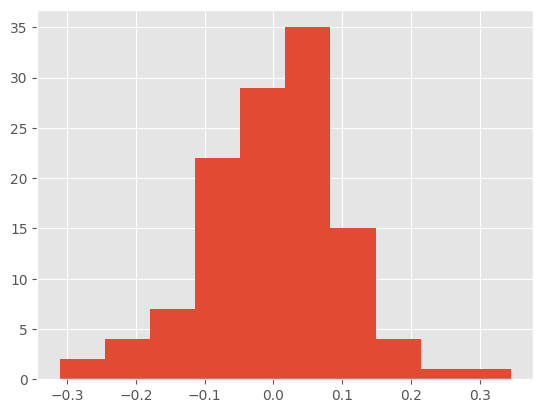

In [ ]:
# Prueba de Anderson Darling
ad_test = anderson(Banamex_reg_mult.resid)

# Mostrar los resultados
print("Estadístico de Anderson-Darling:", ad_test.statistic)
print("Valores críticos:", ad_test.critical_values)
print("Niveles de significancia:", ad_test.significance_level)

plt.hist(Banamex_reg_mult.resid)  # HISTOGRAMA

In [ ]:
# Prueba de Durbin-Watson
dw_statistic = durbin_watson(Banamex_reg_mult.resid)

print(f"Durbin-Watson statistic: {dw_statistic}")

Durbin-Watson statistic: 0.6182024621723762


In [ ]:
bp_test = het_breuschpagan(Banamex_reg_mult.resid, Banamex_reg_mult.model.exog)
print("Breusch-Pagan Test:")
print(f"Estadístico BP: {bp_test[0]}")
print(f"P-valor: {bp_test[1]}")

Breusch-Pagan Test:
Estadístico BP: 33.84972880604789
P-valor: 0.0003827310435229473


## **ANOVA**

In [ ]:
# Lista de variables predictoras
significativas = ["TC","SMG","Bal_com","Deuda_Pub","Ing_Gob","ICC","RMRPO","TICH","TIN","Prod_Edif","Rem_Manu"]

# Ajustar el modelo correctamente con ols()
formula = "Banamex_Score ~ " + " + ".join(significativas)
Banamex_reg_mult = ols(formula, data=variables_modelo).fit()

# Aplicar ANOVA correctamente
anova_results = anova_lm(Banamex_reg_mult, typ=2)  # ANOVA tipo II (el más usado en regresión múltiple)
print(anova_results)

             sum_sq     df          F        PR(>F)
TC         0.094157    1.0   8.170327  5.110614e-03
SMG        1.109907    1.0  96.310029  1.237228e-16
Bal_com    0.309440    1.0  26.851049  1.029816e-06
Deuda_Pub  0.663994    1.0  57.616799  1.201246e-11
Ing_Gob    0.871797    1.0  75.648513  4.177447e-14
ICC        0.130793    1.0  11.349343  1.047129e-03
RMRPO      0.253033    1.0  21.956427  8.175198e-06
TICH       0.031788    1.0   2.758304  9.965127e-02
TIN        0.575504    1.0  49.938256  1.631754e-10
Prod_Edif  0.586305    1.0  50.875463  1.178402e-10
Rem_Manu   0.124884    1.0  10.836535  1.345243e-03
Residual   1.244626  108.0        NaN           NaN


## **PENALIZACIÓN RIDGE**

In [510]:
# Definir las variables predictoras y la respuesta
X = variables_modelo.to_numpy() # Convertir a matriz
y = PD_bancos['Banamex'] # Convertir a vector

# Calcular lambda_max
lambda_max = np.max(np.abs(X.T @ y)) / X.shape[0]

# Crear la secuencia logarítmica de 100 valores
lambda_seq = np.exp(np.linspace(np.log(lambda_max), np.log(lambda_max / 1000), 100))

# Configurar validación cruzada con 10 folds
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Validación cruzada para elegir el mejor lambda
ridge_cv = RidgeCV(alphas=lambda_seq,store_cv_values=True)
ridge_cv.fit(X, y)

# Obtener el mejor lambda
lambda_optimo = round(ridge_cv.alpha_,8)
print("Mejor lambda:", lambda_optimo)


Mejor lambda: 0.06921569


In [512]:
# Ajustar Ridge con la mejor penalización
ridge = Ridge(alpha=lambda_optimo)
ridge.fit(X, y)

# Coeficientes del modelo Ridge
coeficientes = ridge.coef_
print("Coeficientes del modelo Ridge:", coeficientes)

# Predicciones con Ridge
y_pred_ridge = ridge.predict(X)
y_pred_ridge

Coeficientes del modelo Ridge: [-1.21007386 -7.24052505  0.85246485 -0.02819807 -0.38462889  5.67006542
 -0.43431409 -1.28003353 -0.17821232 -0.30106334  0.22133889 -0.10141705
  0.62726862 -3.14832237  0.29148459  0.93037506  0.47325254 -0.16669521
 -0.29148459 -0.02819807  0.14920966 -0.0966675   0.55085413  2.00097578
 -0.47486551  0.24933211 -0.55278266 -0.05512928  1.0664421  -0.54472358]


array([18.05490616, 18.24349174, 18.51164492, 18.21906566, 18.48715988,
       17.00545371, 17.97705218, 18.55265497, 18.72934259, 17.89835427,
       16.89577827, 17.82880529, 17.56610075, 17.8278543 , 17.5607988 ,
       17.18633673, 17.15658689, 17.63812369, 16.25661832, 16.70295612,
       15.83329136, 15.53177171, 16.25620822, 15.74317366, 13.30461496,
       14.70132043, 14.4869085 , 15.22729292, 15.48522469, 15.08134385,
       14.77495911, 15.44632699, 16.00450994, 15.16990793, 14.1409325 ,
       13.49073588, 14.31629206, 13.79998154, 15.07017121, 15.44505774,
       15.7066119 , 15.40252785, 15.04295396, 15.3382287 , 15.27147883,
       15.29721649, 14.54556546, 16.46473249, 16.29823934, 16.85504558,
       16.43287372, 16.06511185, 15.49823994, 15.92937869, 15.59821515,
       15.6307938 , 15.97145135, 15.69537158, 15.8043455 , 15.49234261,
       16.29233415, 16.73628885, 15.96201256, 17.44190963, 16.23492324,
       18.67320273, 17.04521662, 16.50797408, 16.17235058, 16.18

In [513]:
# Comparación de valores reales vs predichos
comparacion = pd.DataFrame()

comparacion= comparacion.assign(PD_Banamex =PD_bancos["Banamex"] / 100,Score_Banamex=Banamex_Score,
                                PD_Ridge = y_pred_ridge / 100)

comparacion = comparacion.assign(Score_Ridge=np.log((comparacion["PD_Ridge"]) / (1 - comparacion["PD_Ridge"])),
                                 Cuadrado_Errores=(comparacion["PD_Banamex"] - comparacion["PD_Ridge"])**2,
                                 Cuadrado_Total=(comparacion["PD_Banamex"]-np.mean(comparacion["PD_Banamex"]))**2)

comparacion.head()

,PD_Banamex,Score_Banamex,PD_Ridge,Score_Ridge,Cuadrado_Errores,Cuadrado_Total
0,0.177788,-1.531407,0.180549,-1.512632,7.624290e-06,0.001218
1,0.181774,-1.504377,0.182435,-1.499937,4.373804e-07,0.001512
2,0.183118,-1.495362,0.185116,-1.482060,3.992480e-06,0.001618
3,0.184860,-1.483758,0.182191,-1.501576,7.127690e-06,0.001761
4,0.183649,-1.491818,0.184872,-1.483684,1.494723e-06,0.001661


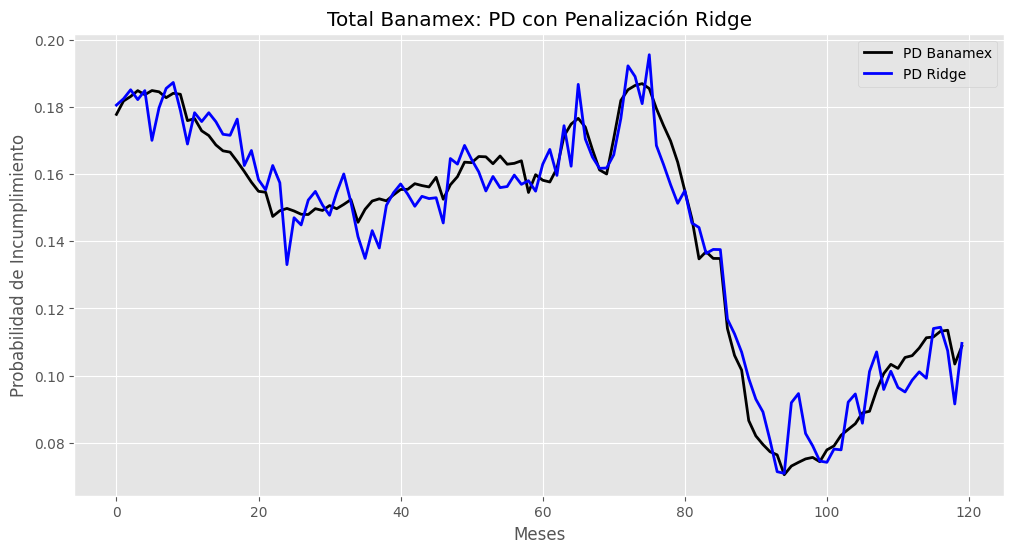

In [514]:
# Gráfico de la penalización Ridge
plt.figure(figsize=(12, 6))
plt.plot(comparacion["PD_Banamex"], label="PD Banamex", linewidth=2,color="black")
plt.plot(comparacion["PD_Ridge"], label="PD Ridge", linewidth=2, color="blue")
plt.title("Total Banamex: PD con Penalización Ridge")
plt.xlabel("Meses")
plt.ylabel("Probabilidad de Incumplimiento")
plt.legend()
plt.show()

In [515]:
# Función que calcula el R^2 ajustado
def adj_r_cuadrado(df):
  numerador=np.sum(df["Cuadrado_Errores"])/(120 - variables_modelo.shape[1]-1)
  denominador=np.sum(df["Cuadrado_Total"]) / (120-1)
  return(1-(numerador / denominador))
print("El coeficiente de determinación R^2 ajustado es: ",adj_r_cuadrado(comparacion),"\n")

# Métricas
MAE_Ridge=np.mean(abs(comparacion["PD_Banamex"] - comparacion["PD_Ridge"]))
MSE_Ridge=np.mean((comparacion["PD_Banamex"] - comparacion["PD_Ridge"])**2)
RMSE_Ridge=np.sqrt(MSE_Ridge)
MAPE_Ridge=np.mean(abs((comparacion["PD_Banamex"] - comparacion["PD_Ridge"]) / comparacion["PD_Banamex"])) * 100

# Mostrar resultados
print("MAE Ridge:", MAE_Ridge, "\n")
print("MSE Ridge:", MSE_Ridge, "\n")
print("RMSE Ridge:", RMSE_Ridge, "\n")
print("MAPE Ridge:", MAPE_Ridge,"%\n")

El coeficiente de determinación R^2 ajustado es:  0.9406060312154292 

MAE Ridge: 0.00586280894383735 

MSE Ridge: 5.3398725466467464e-05 

RMSE Ridge: 0.007307443155199188 

MAPE Ridge: 4.598146219591535 %



## $\textbf{INTERPRETACIÓN}$

Respecto a la regresión, el **R2** de 0.89 es bueno pero se debe tener cuidado ya que Banamex es el primer banco en el que no se cumplen dos de los supuestos, el de Autocorrelación (el DW sigue indicando autocorrelación positiva al no ser cercano a 2) y ahora el de Varianza Constante (prueba de Breusch Pagan con un valor p menor al nivel de significancia), lo que sugiere problemas de heterocedasticidad, es decir, la varianza de los errores no es constante, por lo que el análisis de los modelos con penalización se hará de forma más detallada para ver el modelo que predice con menos errores.
El modelo con penalización Ridge tiene un rendimiento muy bueno. El **r-cuadrado** ajustado es de 0.94, lo que
indica que explica casi el 94% de la variabilidad de los datos. El MAE es de 0.0058 y el RMSE de 0.0073,l o que muestra que los errores de predicción son muy pequeños. Además, el MAPE es de solo 4.6%, lo cual es excelente. En general, el modelo Ridge es preciso, consistente y tiene un muy buen ajuste.

El **ANOVA** indica que todas las variables tienen un impacto significativo en Score_Banamex, lo que sugiere
que el desempeño financiero está influenciado por factores económicos clave. SMG (Salario Mínimo General)
es la variable con mayor peso, lo que refleja la relación entre el poder adquisitivo y la actividad financiera.
Prod_Edif (Producción del sector de edificaciones) también es relevante, ya que el crecimiento en construcción
impulsa el empleo y la inversión. Ing_Gob (Ingresos del Gobierno) y Deuda_Pub (Deuda Pública)
afectan la estabilidad económica y la percepción de riesgo, lo que repercute en el sistema financiero. TC
(Tipo de Cambio) es crucial, pues su volatilidad influye en la inversión y el comercio. Las tasas de interés
(TICH y TIN) determinan el acceso al crédito y el ahorro, mientras que los ingresos laborales (RMRPO) y
las remesas en manufactura (Rem_Manu) reflejan el impacto del empleo en la economía.


# $\textbf{SANTANDER}$

In [550]:
Santander_Score=pd.DataFrame(data=np.log((PD_bancos/100)/(1-PD_bancos/100)),columns=["Santander"])
Santander_Score

,Santander
0,-1.665151
1,-1.681349
2,-1.699997
3,-1.689138
4,-1.690983
...,...
115,-1.754858
116,-1.745540
117,-1.739821
118,-1.788760


In [551]:
significativas=["TC","SMG","Deuda_Pub","Ing_Gob","ICC","TICH","TIN","Participacion_Urbana","May_Text_Calz","Prod_Edif"]
predictoras=sm.add_constant(variables_modelo[significativas])  # B0
Santander_reg_mult= sm.OLS(Santander_Score,predictoras)
# variable y, variables predictoras
Santander_reg_mult = Santander_reg_mult.fit()
print(Santander_reg_mult.summary())

                            OLS Regression Results                            
Dep. Variable:              Santander   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     31.99
Date:                Mon, 24 Mar 2025   Prob (F-statistic):           5.24e-28
Time:                        05:39:56   Log-Likelihood:                 138.17
No. Observations:                 120   AIC:                            -254.3
Df Residuals:                     109   BIC:                            -223.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.7531 

In [552]:
comparacion = pd.DataFrame()
comparacion= comparacion.assign(PD_Santander =PD_bancos["Santander"] / 100,Score_Santander=Santander_Score,
                                Score_Predicho = Santander_reg_mult.predict())
comparacion = comparacion.assign(PD_Predicha=1/(1+np.exp(-1*comparacion["Score_Predicho"])))
comparacion

,PD_Santander,Score_Santander,Score_Predicho,PD_Predicha
0,0.159072,-1.665151,-1.629834,0.163853
1,0.156917,-1.681349,-1.664254,0.159192
2,0.154466,-1.699997,-1.650812,0.160999
3,0.155889,-1.689138,-1.720964,0.151747
4,0.155647,-1.690983,-1.705963,0.153688
...,...,...,...,...
115,0.147435,-1.754858,-1.785500,0.143625
116,0.148611,-1.745540,-1.720397,0.151820
117,0.149336,-1.739821,-1.761636,0.146586
118,0.143225,-1.788760,-1.835008,0.137643


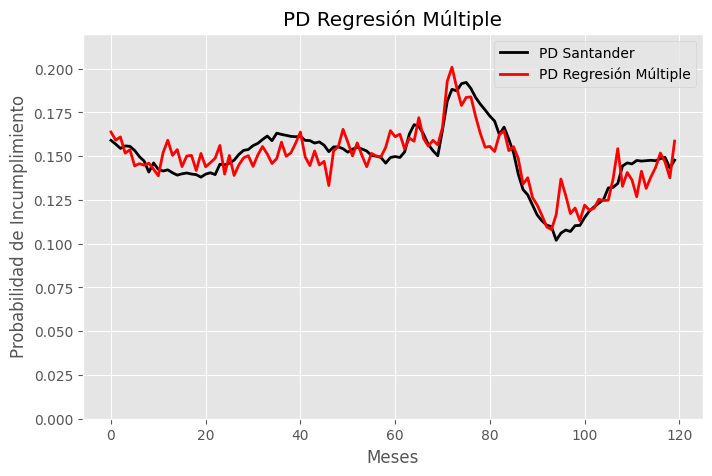

In [553]:
# Gráfica
plt.figure(figsize=(8, 5))
plt.plot(comparacion["PD_Santander"], label="PD Santander", linewidth=2, color='black')
plt.plot(comparacion['PD_Predicha'], label="PD Regresión Múltiple", linewidth=2, color='red')

# Agregar etiquetas y título
plt.ylim(0, 0.22)
plt.title("PD Regresión Múltiple")
plt.xlabel("Meses")
plt.ylabel("Probabilidad de Incumplimiento")

# Agregar leyenda
plt.legend(loc='upper right', fontsize=10)

# Mostrar la gráfica
plt.show()

## **SUPUESTOS**

Lo que se va a hacer es un Análisis de Varianza ANOVA para el modelo de regresión múltiple, así como la verificación de los 4 supuestos para los errores a través del valor p y de los estadísticos de las pruebas
adecuadas para cada uno.
* Media Cero: Calcular la media
* Normalidad: Prueba de Anderson Darling
* Independencia: Prueba de Durbin Watson
* Varianza Constante: Prueba de Breusch Pagan

Al final se van a comparar los modelos que presentan penalización y también se dará una interpretación de
lo que representan las variables ante el planteamiento de que las personas dejen de pagar sus tarjetas de
crédito.

In [ ]:
print(f"Media de los residuales: {Santander_reg_mult.resid.mean()}")


Media de los residuales: -3.7007434154171886e-16


Estadístico de Anderson-Darling: 0.29926067602659145
Valores críticos: [0.558 0.636 0.763 0.89  1.059]
Niveles de significancia: [15.  10.   5.   2.5  1. ]


(array([ 1.,  0.,  2.,  5., 18., 26., 33., 20., 11.,  4.]),
 array([-0.29086479, -0.24421654, -0.19756829, -0.15092004, -0.10427178,
        -0.05762353, -0.01097528,  0.03567297,  0.08232122,  0.12896947,
         0.17561772]),
 <BarContainer object of 10 artists>)

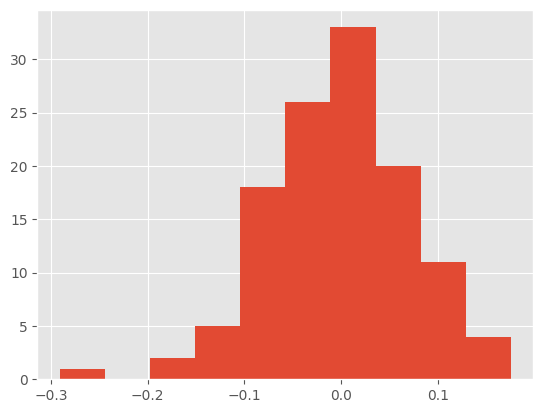

In [ ]:
# Prueba de Anderson Darling
ad_test = anderson(Santander_reg_mult.resid)

# Mostrar los resultados
print("Estadístico de Anderson-Darling:", ad_test.statistic)
print("Valores críticos:", ad_test.critical_values)
print("Niveles de significancia:", ad_test.significance_level)

plt.hist(Santander_reg_mult.resid)  # HISTOGRAMA

In [ ]:
# Prueba de Durbin-Watson
dw_statistic = durbin_watson(Santander_reg_mult.resid)

print(f"Durbin-Watson statistic: {dw_statistic}")

Durbin-Watson statistic: 0.7672500344390584


In [ ]:
bp_test = het_breuschpagan(Santander_reg_mult.resid, Santander_reg_mult.model.exog)
print("Breusch-Pagan Test:")
print(f"Estadístico BP: {bp_test[0]}")
print(f"P-valor: {bp_test[1]}")

Breusch-Pagan Test:
Estadístico BP: 11.168240353679582
P-valor: 0.34456170294715666


## **ANOVA**

In [ ]:
# Lista de variables predictoras
significativas = ["TC","SMG","Deuda_Pub","Ing_Gob","ICC","RMRPO","TICH","TIN","Participacion_Urbana","May_Text_Calz","Prod_Edif"]

# Ajustar el modelo correctamente con ols()
formula = "Santander_Score ~ " + " + ".join(significativas)
Santander_reg_mult = ols(formula, data=variables_modelo).fit()

# Aplicar ANOVA correctamente
anova_results = anova_lm(Santander_reg_mult, typ=2)  # ANOVA tipo II (el más usado en regresión múltiple)
print(anova_results)

                        sum_sq     df           F        PR(>F)
TC                    0.175697    1.0   27.021719  9.595812e-07
SMG                   0.720743    1.0  110.848573  2.919342e-18
Deuda_Pub             0.677881    1.0  104.256488  1.545227e-17
Ing_Gob               0.408748    1.0   62.864435  2.170189e-12
ICC                   0.104071    1.0   16.005908  1.159622e-04
RMRPO                 0.000183    1.0    0.028177  8.670078e-01
TICH                  0.063995    1.0    9.842304  2.198269e-03
TIN                   0.327901    1.0   50.430360  1.375052e-10
Participacion_Urbana  0.177068    1.0   27.232718  8.794614e-07
May_Text_Calz         0.035686    1.0    5.488473  2.097414e-02
Prod_Edif             0.363985    1.0   55.980088  2.072286e-11
Residual              0.702221  108.0         NaN           NaN


## **PENALIZACIÓN RIDGE**

In [554]:
# Definir las variables predictoras y la respuesta
X = variables_modelo.to_numpy() # Convertir a matriz
y = PD_bancos['Santander'] # Convertir a vector

# Calcular lambda_max
lambda_max = np.max(np.abs(X.T @ y)) / X.shape[0]

# Crear la secuencia logarítmica de 100 valores
lambda_seq = np.exp(np.linspace(np.log(lambda_max), np.log(lambda_max / 1000), 100))

# Configurar validación cruzada con 10 folds
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Validación cruzada para elegir el mejor lambda
ridge_cv = RidgeCV(alphas=lambda_seq,store_cv_values=True)
ridge_cv.fit(X, y)

# Obtener el mejor lambda
lambda_optimo = round(ridge_cv.alpha_,8)
print("Mejor lambda:", lambda_optimo)


Mejor lambda: 0.05201782


In [555]:
# Ajustar Ridge con la mejor penalización
ridge = Ridge(alpha=lambda_optimo)
ridge.fit(X, y)

# Coeficientes del modelo Ridge
coeficientes = ridge.coef_
print("Coeficientes del modelo Ridge:", coeficientes)

# Predicciones con Ridge
y_pred_ridge = ridge.predict(X)
y_pred_ridge

Coeficientes del modelo Ridge: [-1.37814237e+00 -7.57470814e+00  1.26033862e+00 -1.65598554e-02
 -4.46464020e-02  7.03949764e+00  1.47130339e-01 -1.17670983e+00
 -6.63545844e-02 -3.52201553e-01  7.35673208e-02 -4.56809427e-03
  8.20542920e-01 -2.86633323e+00  1.37860345e-01  4.33920977e-01
  4.53734359e-01 -1.11852151e-01 -1.37860345e-01 -1.65598554e-02
  3.89569446e-03 -4.31418668e-01  8.81833326e-01  1.98926380e+00
 -3.30714685e-01  7.29579521e-02 -7.13169811e-01  1.51631060e-01
  1.06276263e+00 -3.93790084e-01]


array([15.12082476, 15.56546952, 15.96052603, 15.32790736, 15.37068857,
       14.17517855, 14.89224973, 15.3506084 , 15.13046502, 14.50150029,
       13.65829172, 14.27730397, 14.61074066, 14.76372282, 15.08973651,
       14.4482158 , 14.55740543, 15.16441121, 14.21524486, 15.1253858 ,
       14.30993041, 14.52320918, 15.16055531, 14.75028378, 13.64233624,
       14.89346666, 14.23875049, 15.19337684, 14.95866821, 15.2932494 ,
       15.20650408, 15.61248425, 16.2202554 , 15.65523147, 14.64075392,
       14.58393709, 15.34402025, 14.59117551, 15.6503731 , 16.589087  ,
       16.10588681, 16.27602311, 15.25904338, 15.62552636, 15.48508849,
       15.15267555, 14.36634453, 15.78350914, 15.26770422, 16.01799952,
       15.53868459, 15.34926461, 14.81858618, 15.27590644, 14.62766905,
       15.00730365, 15.05000124, 14.9011961 , 15.04748863, 15.24053888,
       15.51477385, 15.46818797, 14.46998341, 16.6905918 , 15.80106929,
       17.85231234, 15.73938545, 15.24981362, 14.92825422, 14.57

In [556]:
# Comparación de valores reales vs predichos
comparacion = pd.DataFrame()

comparacion= comparacion.assign(PD_Santander =PD_bancos["Santander"] / 100,Score_Santander=Santander_Score,
                                PD_Ridge = y_pred_ridge / 100)

comparacion = comparacion.assign(Score_Ridge=np.log((comparacion["PD_Ridge"]) / (1 - comparacion["PD_Ridge"])),
                                 Cuadrado_Errores=(comparacion["PD_Santander"] - comparacion["PD_Ridge"])**2,
                                 Cuadrado_Total=(comparacion["PD_Santander"]-np.mean(comparacion["PD_Santander"]))**2)

comparacion.head()

,PD_Santander,Score_Santander,PD_Ridge,Score_Ridge,Cuadrado_Errores,Cuadrado_Total
0,0.159072,-1.665151,0.151208,-1.725156,0.000062,0.000108
1,0.156917,-1.681349,0.155655,-1.690921,0.000002,0.000068
2,0.154466,-1.699997,0.159605,-1.661168,0.000026,0.000034
3,0.155889,-1.689138,0.153279,-1.709111,0.000007,0.000052
4,0.155647,-1.690983,0.153707,-1.705818,0.000004,0.000049


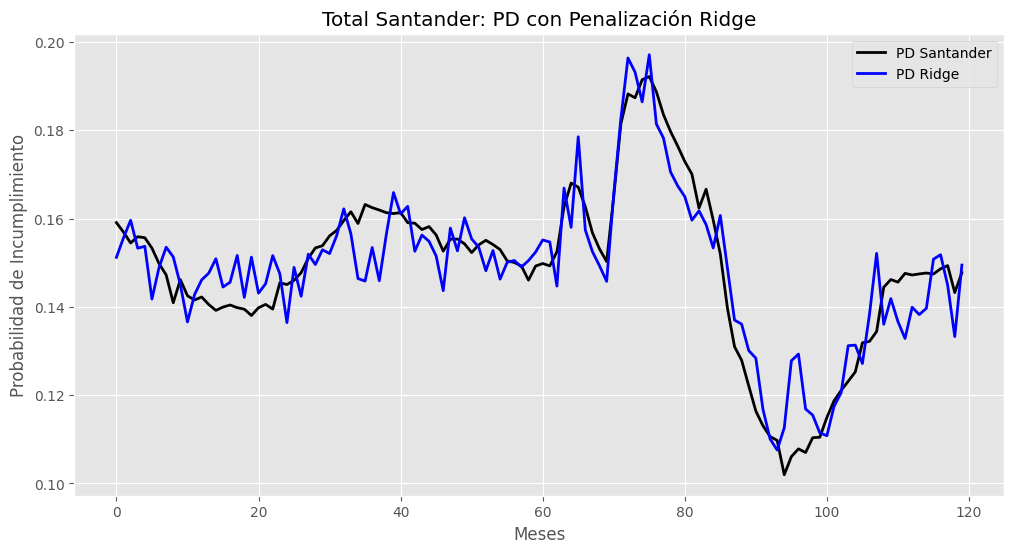

In [557]:
# Gráfico de la penalización Ridge
plt.figure(figsize=(12, 6))
plt.plot(comparacion["PD_Santander"], label="PD Santander", linewidth=2,color="black")
plt.plot(comparacion["PD_Ridge"], label="PD Ridge", linewidth=2, color="blue")
plt.title("Total Santander: PD con Penalización Ridge")
plt.xlabel("Meses")
plt.ylabel("Probabilidad de Incumplimiento")
plt.legend()
plt.show()

In [558]:
# Función que calcula el R^2 ajustado
def adj_r_cuadrado(df):
  numerador=np.sum(df["Cuadrado_Errores"])/(120 - variables_modelo.shape[1]-1)
  denominador=np.sum(df["Cuadrado_Total"]) / (120-1)
  return(1-(numerador / denominador))
print("El coeficiente de determinación R^2 ajustado es: ",adj_r_cuadrado(comparacion),"\n")

# Métricas
MAE_Ridge=np.mean(abs(comparacion["PD_Santander"] - comparacion["PD_Ridge"]))
MSE_Ridge=np.mean((comparacion["PD_Santander"] - comparacion["PD_Ridge"])**2)
RMSE_Ridge=np.sqrt(MSE_Ridge)
MAPE_Ridge=np.mean(abs((comparacion["PD_Santander"] - comparacion["PD_Ridge"]) / comparacion["PD_Santander"])) * 100

# Mostrar resultados
print("MAE Ridge:", MAE_Ridge, "\n")
print("MSE Ridge:", MSE_Ridge, "\n")
print("RMSE Ridge:", RMSE_Ridge, "\n")
print("MAPE Ridge:", MAPE_Ridge,"%\n")

El coeficiente de determinación R^2 ajustado es:  0.7876262002870906 

MAE Ridge: 0.005979127622920997 

MSE Ridge: 5.459637556823818e-05 

RMSE Ridge: 0.007388936024099693 

MAPE Ridge: 4.158275272623413 %



# $\textbf{INTERPRETACIÓN}$

El modelo tiene un alto poder explicativo, como lo indica el R-cuadrado de 0.723. Todas las variables incluidas en el modelo son estadísticamente significativas, lo que sugiere que cada una de ellas contribuye fuertemente a la predicción de Santander, algunas con un impacto positivo (lo que sugiere que aumentos en estas variables están asociados con un aumento en el score) y otras con un impacto negativo (lo que indica que aumentos en estas variables están asociados con una disminución en el score).
Lo siguiente a remarcar son los supuestos, todos cumplen con un buen resultado, la media de los errores tiene un valor muy cercano a cero, mientras que los valores-p para la homoscesdasticidad (varianza constante) y la normalidad superan el valor de alpha usado (0.05), por otro lado, se resalta un valor de 0.76 en la prueba de Durbin-Watson para la prueba de autocorrelación, a pesar de ser un valor más cercano a 1 que a 0, se puede asumir que no hay una autocorrelación positiva significativa, pero esto se explica a la cantidad
de variables de impacto positivo en el modelo.

Respecto a la penalización ridge, esta si hace un ajuste más eficiente que el modelo con la regresión de variables significtivas, lo más importante a recalcar es que aún mantiene un MPA bajo del 4.1% y que el R-cuadrado ajustado lo sube en 0.6 puntos porcentuales aproximadamente.

Comparando el modelo OLS con el ANOVA, tenemos pocas diferencias, así que procedemos a revisar las variables significativas y su relación directa con Santander.

* ICC: Una de las dos variables que no tienen presencia en el ANOVA, representa la confianza del consumidor respecto a su situación económica, esta variable tuvo un impacto positivo en el modelo, esto debido a que probablemente los clientes de Santander han visto mejorías en su economía personal al estar en este banco, influyendo en el consumo y la inversión sobre este.

* TICH: La segunda variable que no tiene presencia en el ANOVA, representa las tasas de interés fijas, esta variable tuvo un impacto positivo en el modelo, los productos que ofrece Santander son variados y probablemente haya clientes que tenga más de uno, con tasas que varían desde el 4.9%-11.75% en préstamos personales, liquidez del 8.2%, hipotécas del 11.35%, etc.

* TC: El tipo de cambio tuvo un impacto negativo, recordemos que Santander es un banco extranjero, por lo que si el peso se devalua, se disminuye el poder adquisitivo y habrá más cargas relacionadas a distintas deudas.

* SMG: El Banco Santander ha expresado su opinión sobre el aumento del salario mínimo en México, considerando que es mejor que no aumente demasiado para evitar presiones a la inflación, considera que es mejor que el salario mínimo aumente solo 12% en 2025, el salario mínimo en México se fijó en $278.80 MXN diarios, lo que equivale a $8,364 MXN mensuales, estos comentarios se reflejan en un impacto negaivo en el modelo.

* Ing_Gob: El Banco Santander tiene convenios de colaboración con gobiernos estatales y con la Secretaría de Economía. Estos convenios buscan generar inversión y crecimiento en el país, incluso otorgando múltiples becas con su programa de Open Academy, pero la razón de tener un impacto negativo en el modelo puede deberse precisamente por el apoyo que da al gobierno, con ciertos discontentos que ha tenido la población y los sucesos recientes.

* TIN: Se refiere a la tasa promedio ponderada de instrumentos de deuda de corto plazo, el Banco Santander utiliza la tasa de interés nominal para calcular el costo de oportunidad de no tener disponible el dinero que ha prestado. El TIN es el porcentaje que se suma al capital como coste o rentabilidad, presente en muchos de sus productos, con un máximo del 55%, teniendo así un impacto negativo en el modelo.

* Deuda_Pub: Representa la deuda total neta del sector público; El Banco Santander ha comprado deuda pública española y mexicana, y también ofrece fondos de inversión que pueden invertir en deuda pública. En 2022, Santander México tuvo una cuota de mercado del 26,6% en el Mercado de Capitales de Deuda Local. En 2023, Santander México se consolidó como Líder en el Mercado de Capitales de Deuda Local, razón por la que tuvo un impacto positivo en el modelo.

* Participación_Urbana: Representa el porcentaje de la población en edad de trabajar que participa en el mercado laboral, en México, hay una gran parte de la población que tiene empleos informales, razón por la que esta variable tuvo un impacto negativo en el modelo, a pesar de que se puedan solventar los gastos y se disminuya la prob. de incumplimiento, no quita el hecho de que se tiene que participar de forma transparente.

* Prod_edif: Esta variable representa el valor económico generado mediante edificaciones de varios campos; Santander ha tenido un papel respecto al cuidado del medio ambiente e incluso el cambio climático, sus edificios han sido diseñados para ser sostenibles y energéticamente eficientes. Cuentan con la certificación BREEAM “excelente”, que los acredita como sostenibles a nivel mundial, tanto en su construcción como en su explotación, minimizando así el impacto ambiental, razón por la cual tuvo un impacto positivo en el modelo.

* May_Text_Calz: Esta variable representa la actividad económica de comercios al por mayor relacionada a los textiles y calzado; Santander tenía un valor bursátil de 74000 millones en 2019 en temas de textiles y calzado, esto cambió debido a su relación con la empresa INDITEX, un lider mundial
textil, donde ahora cotizan alrededor de 143200 millones sólo en este sector, a un tipo de cambio de aproximadamente 10.6%, gracias a tendencias como el fast fashion.


In [524]:
# Función que calcula el R^2 ajustado
def adj_r_cuadrado(df):
  numerador=np.sum(df["Cuadrado_Errores"])/(120 - variables_modelo.shape[1]-1)
  denominador=np.sum(df["Cuadrado_Total"]) / (120-1)
  return(1-(numerador / denominador))
print("El coeficiente de determinación R^2 ajustado es: ",adj_r_cuadrado(comparacion),"\n")

# Métricas
MAE_Ridge=np.mean(abs(comparacion["PD_Santander"] - comparacion["PD_Ridge"]))
MSE_Ridge=np.mean((comparacion["PD_Santander"] - comparacion["PD_Ridge"])**2)
RMSE_Ridge=np.sqrt(MSE_Ridge)
MAPE_Ridge=np.mean(abs((comparacion["PD_Santander"] - comparacion["PD_Ridge"]) / comparacion["PD_Santander"])) * 100

# Mostrar resultados
print("MAE Ridge:", MAE_Ridge, "\n")
print("MSE Ridge:", MSE_Ridge, "\n")
print("RMSE Ridge:", RMSE_Ridge, "\n")
print("MAPE Ridge:", MAPE_Ridge,"%\n")

El coeficiente de determinación R^2 ajustado es:  0.7876262002870906 

MAE Ridge: 0.005979127622920997 

MSE Ridge: 5.459637556823818e-05 

RMSE Ridge: 0.007388936024099693 

MAPE Ridge: 4.158275272623413 %



# $\textbf{BBVA}$

In [525]:
BBVA_Score=pd.DataFrame(data=np.log((PD_bancos/100)/(1-PD_bancos/100)),columns=["BBVA"])
BBVA_Score

,BBVA
0,-1.704305
1,-1.694119
2,-1.670143
3,-1.665175
4,-1.667630
...,...
115,-1.953366
116,-1.933012
117,-1.924359
118,-1.976385


In [527]:
significativas=["TC","SMG","Deuda_Pub","Ing_Gob","TIN","Participacion_Urbana","Prod_Edif"]
predictoras=sm.add_constant(variables_modelo[significativas])  # B0
BBVA_reg_mult= sm.OLS(BBVA_Score,predictoras)
# variable y, variables predictoras
BBVA_reg_mult = BBVA_reg_mult.fit()
print(BBVA_reg_mult.summary())

                            OLS Regression Results                            
Dep. Variable:                   BBVA   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     53.35
Date:                Mon, 24 Mar 2025   Prob (F-statistic):           8.62e-33
Time:                        05:00:06   Log-Likelihood:                 120.41
No. Observations:                 120   AIC:                            -224.8
Df Residuals:                     112   BIC:                            -202.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.8891 

In [528]:
comparacion = pd.DataFrame()
comparacion= comparacion.assign(PD_BBVA =PD_bancos["BBVA"] / 100,Score_BBVA=BBVA_Score,
                                Score_Predicho = BBVA_reg_mult.predict())
comparacion = comparacion.assign(PD_Predicha=1/(1+np.exp(-1*comparacion["Score_Predicho"])))
comparacion

,PD_BBVA,Score_BBVA,Score_Predicho,PD_Predicha
0,0.153904,-1.704305,-1.676302,0.157586
1,0.155235,-1.694119,-1.678004,0.157360
2,0.158405,-1.670143,-1.681370,0.156914
3,0.159069,-1.665175,-1.750776,0.147949
4,0.158740,-1.667630,-1.720117,0.151856
...,...,...,...,...
115,0.124187,-1.953366,-2.014949,0.117642
116,0.126418,-1.933012,-1.944474,0.125157
117,0.127376,-1.924359,-2.030339,0.116054
118,0.121705,-1.976385,-2.115800,0.107571


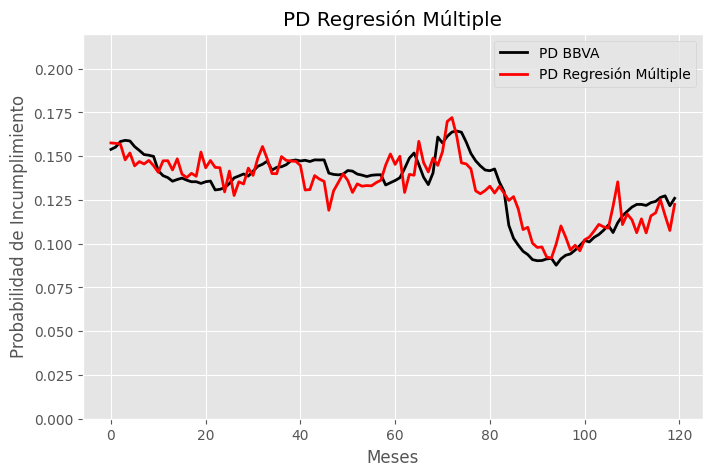

In [529]:
# Gráfica
plt.figure(figsize=(8, 5))
plt.plot(comparacion["PD_BBVA"], label="PD BBVA", linewidth=2, color='black')
plt.plot(comparacion['PD_Predicha'], label="PD Regresión Múltiple", linewidth=2, color='red')

# Agregar etiquetas y título
plt.ylim(0, 0.22)
plt.title("PD Regresión Múltiple")
plt.xlabel("Meses")
plt.ylabel("Probabilidad de Incumplimiento")

# Agregar leyenda
plt.legend(loc='upper right', fontsize=10)

# Mostrar la gráfica
plt.show()

## **SUPUESTOS**

Lo que se va a hacer es un Análisis de Varianza ANOVA para el modelo de regresión múltiple, así como la verificación de los 4 supuestos para los errores a través del valor p y de los estadísticos de las pruebas
adecuadas para cada uno.
* Media Cero: Calcular la media
* Normalidad: Prueba de Anderson Darling
* Independencia: Prueba de Durbin Watson
* Varianza Constante: Prueba de Breusch Pagan

Al final se van a comparar los modelos que presentan penalización y también se dará una interpretación de
lo que representan las variables ante el planteamiento de que las personas dejen de pagar sus tarjetas de
crédito.

In [530]:
print(f"Media de los residuales: {BBVA_reg_mult.resid.mean()}")


Media de los residuales: -3.090120751873352e-16


Estadístico de Anderson-Darling: 0.4056817707234046
Valores críticos: [0.558 0.636 0.763 0.89  1.059]
Niveles de significancia: [15.  10.   5.   2.5  1. ]


(array([ 2.,  3., 10., 11., 24., 23., 19., 16.,  8.,  4.]),
 array([-0.23500946, -0.19221151, -0.14941357, -0.10661562, -0.06381767,
        -0.02101973,  0.02177822,  0.06457617,  0.10737411,  0.15017206,
         0.19297001]),
 <BarContainer object of 10 artists>)

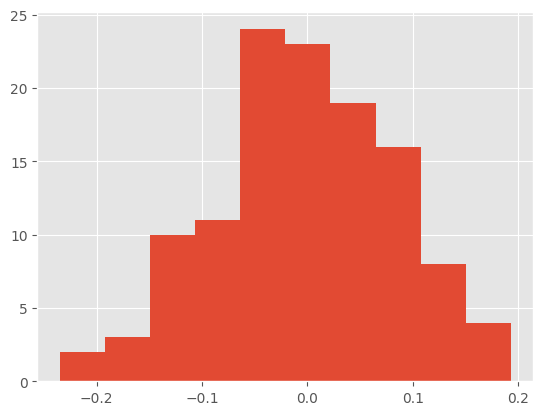

In [531]:
# Prueba de Anderson Darling
ad_test = anderson(BBVA_reg_mult.resid)

# Mostrar los resultados
print("Estadístico de Anderson-Darling:", ad_test.statistic)
print("Valores críticos:", ad_test.critical_values)
print("Niveles de significancia:", ad_test.significance_level)

plt.hist(Santander_reg_mult.resid)  # HISTOGRAMA

In [532]:
# Prueba de Durbin-Watson
dw_statistic = durbin_watson(BBVA_reg_mult.resid)

print(f"Durbin-Watson statistic: {dw_statistic}")

Durbin-Watson statistic: 0.6796914191654908


In [533]:
bp_test = het_breuschpagan(BBVA_reg_mult.resid,BBVA_reg_mult.model.exog)
print("Breusch-Pagan Test:")
print(f"Estadístico BP: {bp_test[0]}")
print(f"P-valor: {bp_test[1]}")

Breusch-Pagan Test:
Estadístico BP: 15.06025662839345
P-valor: 0.03523471364158309


## **ANOVA**

In [534]:
# Lista de variables predictoras
significativas = ["TC","SMG","Deuda_Pub","Ing_Gob","TIN","Participacion_Urbana","Prod_Edif"]

# Ajustar el modelo correctamente con ols()
formula = "BBVA_Score ~ " + " + ".join(significativas)
BBVA_reg_mult = ols(formula, data=variables_modelo).fit()

# Aplicar ANOVA correctamente
anova_results = anova_lm(BBVA_reg_mult, typ=2)  # ANOVA tipo II (el más usado en regresión múltiple)
print(anova_results)

                        sum_sq     df           F        PR(>F)
TC                    0.675949    1.0   80.166538  8.536643e-15
SMG                   0.864317    1.0  102.506744  1.691037e-17
Deuda_Pub             0.919180    1.0  109.013396  3.124408e-18
Ing_Gob               0.322714    1.0   38.273361  1.031932e-08
TIN                   0.195193    1.0   23.149607  4.712580e-06
Participacion_Urbana  0.334088    1.0   39.622284  6.181184e-09
Prod_Edif             0.575838    1.0   68.293477  3.180161e-13
Residual              0.944363  112.0         NaN           NaN


## **PENALIZACIÓN RIDGE**

In [535]:
# Definir las variables predictoras y la respuesta
X = variables_modelo.to_numpy() # Convertir a matriz
y = PD_bancos['BBVA'] # Convertir a vector

# Calcular lambda_max
lambda_max = np.max(np.abs(X.T @ y)) / X.shape[0]

# Crear la secuencia logarítmica de 100 valores
lambda_seq = np.exp(np.linspace(np.log(lambda_max), np.log(lambda_max / 1000), 100))

# Configurar validación cruzada con 10 folds
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Validación cruzada para elegir el mejor lambda
ridge_cv = RidgeCV(alphas=lambda_seq,store_cv_values=True)
ridge_cv.fit(X, y)

# Obtener el mejor lambda
lambda_optimo = round(ridge_cv.alpha_,8)
print("Mejor lambda:", lambda_optimo)

Mejor lambda: 0.05265165


In [536]:
# Ajustar Ridge con la mejor penalización
ridge = Ridge(alpha=lambda_optimo)
ridge.fit(X, y)

# Coeficientes del modelo Ridge
coeficientes = ridge.coef_
print("Coeficientes del modelo Ridge:", coeficientes)

# Predicciones con Ridge
y_pred_ridge = ridge.predict(X)
y_pred_ridge

Coeficientes del modelo Ridge: [-1.52391142 -6.54658158  1.00235535 -0.03637866 -0.2311411   6.74944277
 -0.30827089 -0.76925799 -0.15795046  0.10356412 -0.09334984  0.03051896
  0.18811504 -1.52692468  0.08349622  0.2554271   0.67806039 -0.13975718
 -0.08349622 -0.03637866  0.06814217 -0.27227884  0.45222477  1.36194296
 -0.34841918  0.03589248 -0.71096632 -1.11134343  1.06427916  0.2624356 ]


array([15.37496387, 15.31887695, 15.74901415, 15.54842732, 15.40699022,
       14.16829092, 14.94931721, 15.38474814, 15.41607814, 14.99788101,
       14.07687384, 14.52886579, 13.94790303, 14.31242724, 15.05507188,
       14.59211417, 13.98806961, 14.42048103, 13.50096643, 14.41244023,
       13.4562397 , 13.77672439, 14.05804005, 13.72668934, 12.24103989,
       13.63830371, 13.70337542, 14.08831192, 13.88976616, 14.07653665,
       13.80796794, 14.63283969, 15.13901646, 14.55457163, 13.51239836,
       12.71447985, 13.44390325, 13.16510177, 14.71581332, 15.09986943,
       14.54458416, 14.28038242, 13.58423316, 13.89598727, 13.95661939,
       14.16445694, 13.60520885, 14.41868733, 13.61994335, 14.12801886,
       14.5269897 , 14.04549225, 13.50942776, 13.9548383 , 13.88596438,
       14.06165397, 14.29877695, 14.06414894, 13.92696544, 13.74628909,
       14.08724346, 14.33029948, 13.58320193, 15.23657301, 13.89470202,
       15.60915878, 13.75770189, 13.85075599, 14.12804419, 13.97

In [537]:
# Comparación de valores reales vs predichos
comparacion = pd.DataFrame()

comparacion= comparacion.assign(PD_BBVA =PD_bancos["BBVA"] / 100,Score_BBVA=BBVA_Score,
                                PD_Ridge = y_pred_ridge / 100)

comparacion = comparacion.assign(Score_Ridge=np.log((comparacion["PD_Ridge"]) / (1 - comparacion["PD_Ridge"])),
                                 Cuadrado_Errores=(comparacion["PD_BBVA"] - comparacion["PD_Ridge"])**2,
                                 Cuadrado_Total=(comparacion["PD_BBVA"]-np.mean(comparacion["PD_BBVA"]))**2)

comparacion.head()

,PD_BBVA,Score_BBVA,PD_Ridge,Score_Ridge,Cuadrado_Errores,Cuadrado_Total
0,0.153904,-1.704305,0.153750,-1.705490,2.376879e-08,0.000448
1,0.155235,-1.694119,0.153189,-1.709807,4.186977e-06,0.000506
2,0.158405,-1.670143,0.157490,-1.677023,8.371490e-07,0.000659
3,0.159069,-1.665175,0.155484,-1.692219,1.284733e-05,0.000693
4,0.158740,-1.667630,0.154070,-1.703030,2.181318e-05,0.000676


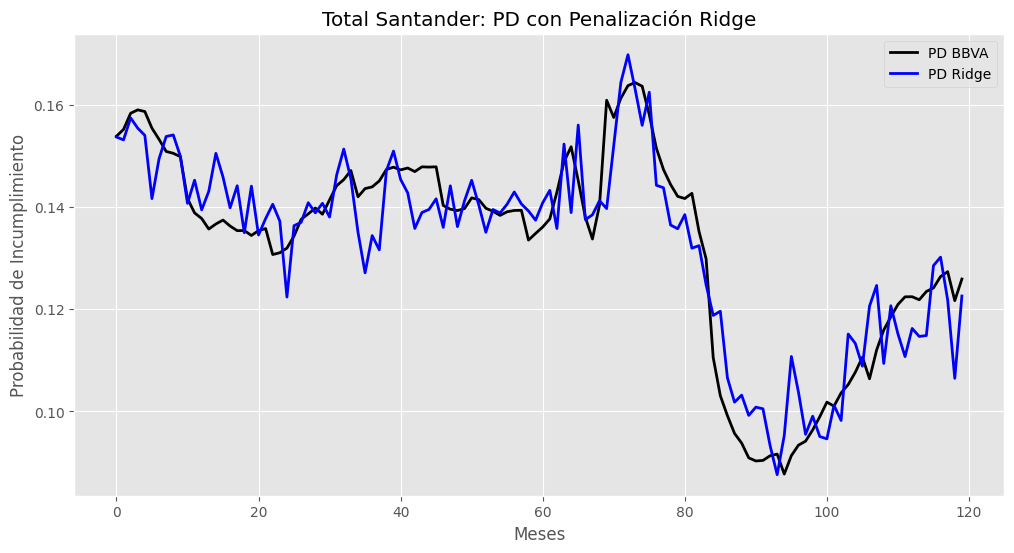

In [538]:
# Gráfico de la penalización Ridge
plt.figure(figsize=(12, 6))
plt.plot(comparacion["PD_BBVA"], label="PD BBVA", linewidth=2,color="black")
plt.plot(comparacion["PD_Ridge"], label="PD Ridge", linewidth=2, color="blue")
plt.title("Total Santander: PD con Penalización Ridge")
plt.xlabel("Meses")
plt.ylabel("Probabilidad de Incumplimiento")
plt.legend()
plt.show()

In [539]:
# Función que calcula el R^2 ajustado
def adj_r_cuadrado(df):
  numerador=np.sum(df["Cuadrado_Errores"])/(120 - variables_modelo.shape[1]-1)
  denominador=np.sum(df["Cuadrado_Total"]) / (120-1)
  return(1-(numerador / denominador))
print("El coeficiente de determinación R^2 ajustado es: ",adj_r_cuadrado(comparacion),"\n")

# Métricas
MAE_Ridge=np.mean(abs(comparacion["PD_BBVA"] - comparacion["PD_Ridge"]))
MSE_Ridge=np.mean((comparacion["PD_BBVA"] - comparacion["PD_Ridge"])**2)
RMSE_Ridge=np.sqrt(MSE_Ridge)
MAPE_Ridge=np.mean(abs((comparacion["PD_BBVA"] - comparacion["PD_Ridge"]) / comparacion["PD_BBVA"])) * 100

# Mostrar resultados
print("MAE Ridge:", MAE_Ridge, "\n")
print("MSE Ridge:", MSE_Ridge, "\n")
print("RMSE Ridge:", RMSE_Ridge, "\n")
print("MAPE Ridge:", MAPE_Ridge,"%\n")

El coeficiente de determinación R^2 ajustado es:  0.8233369157125761 

MAE Ridge: 0.0057314416146121115 

MSE Ridge: 5.178444178227253e-05 

RMSE Ridge: 0.007196140756146487 

MAPE Ridge: 4.560895532109626 %



# $\textbf{INTERPRETACIÓN}$

Antes de brindar un breve análisis de los resultados obtenidos en las pruebas realizadas con anterioridad es nececesario recordar que BBVA es el banco en México que más clientes tiene y que más creditos brinda a los mismos. De esta forma, se podria esperar que en comparación de las otras instituciones presente valores de riesgo más altos, es decir, es un banco con mayor riesgo sistematico.
De las variables macroeconomicas seleccionadas solo las variables “TC”,“SMG”,“Deuda_Pub”,“Ing_Gob”,“TIN”, “Participación_Urbana”,“Prod_Edif” fueron de relevancia para explicar el incumplimiento de pago en tarjetas de crédito de BBVA. El conocer cuales son las variables de relevancia es importante para tener
una idea de como un cambio en estos indicadores afecta directamente a los ingresos por concepto de pago.

Sin embargo, es necesario ahondar un poco más en cada una y ver que factores son los que hacen que esta relación sea tan crucial.

* TC (Tipo de Cambio): Esta variable se relaciona con BBVA, ya que al ser el banco más grande un cambio en el tipo de cambio puede modificar la forma en que sus clientes cumplen con sus obligaciones y también la forma en que sus responsabilidades cambian por efectos de las fluctuaciones.

* SMG (Salario Minimo): Una variación en el salario minimo afecta a los compromisos de los clientes con el banco porque un aumento de salario significa un cambio en la economia de las familias pero también de los provedores de empleos.

* Deuda_Pub” (Deuda Publica): La deuda publica es de gran relevancia, ya que esta es un reflejo de la salud economica de una nación, esta puede dar señales para establcer una politica de credito más inclusiva o restrictiva.

* Ing_Gob (Ingresos Gubernanmentales): Los ingresos guberanmentales se obtienen de los impueestos que se recaudan. Por lo tanto, este indicador es un reflejo del sistema fiscal que brinda una idea de la forma en que se esta gestionando la politica fiscal de la nación, hecho de gran relevancia para la instiucion.

* TIN (Tasa de Interes Nominal): Es de relevancia porque ayuda a las instituciones a conocer como se encuentra la economia y también a establecer tasas para obtener ganancias de los intereses generados por los prestamos.

* Participación_Urbana (Tasa de Participación Urbana): Este indicador muestra como la población economicamente activa participa. Es decir, esto puede estar ligado a la inclusión financiera que existe.



# $\textbf{CONCLUSIÓN}$

El presente estudio nos permitió analizar la probabilidad de incumplimiento en tarjetas de crédito para los principales bancos en México, incluyendo Santander, Banamex, Banorte y el agregado de Total Banca Múltiple (TBM). A través de modelos de regresión múltiple y técnicas de penalización (Ridge, Lasso y Elastic Net), evaluamos los factores económicos que influyen en el comportamiento de pago de los clientes, identificando aquellos que tienen un mayor impacto en la morosidad. Durante el análisis de cada banco, encontramos que el Tipo de cambio (TC), el salario mínimo (SMG), la Deuda pública (Deuda_Pub), la Inversión en construcción (Prod_Edif) y la Confianza del
consumidor (ICC) son variables clave en la predicción del incumplimiento. En particular, el incremento en el salario mínimo mostró un efecto positivo en la reducción de la morosidad, lo que sugiere que una mayor capacidad adquisitiva de los clientes mejora el cumplimiento de sus obligaciones financieras. También
observamos que la deuda pública tiene un impacto negativo, ya que su aumento puede derivar en recortes en el gasto gubernamental, afectando el ingreso de los ciudadanos y su capacidad de pago.
Para cada banco, analizamos distintos modelos de regresión con el fin de identificar la técnica más precisa
y eficiente:

En el análisis de Total Banca Múltiple (TBM), se evaluó el comportamiento agregado del sistema bancario. Se identificó que variables como el salario mínimo, la deuda pública y la inversión en construcción tienen una influencia determinante en la probabilidad de incumplimiento en tarjetas de crédito.
Al considerar toda la banca múltiple, observamos que las relaciones entre estas variables y la morosidad son consistentes con los hallazgos en los bancos individuales. Elastic Net nuevamente mostró un alto desempeño, con un R2 ajustado de 0.88, consolidándose como el modelo más confiable para predecir la
probabilidad de incumplimiento en el sector bancario en su conjunto.

Para Banorte, las variables más significativas fueron la inversión en construcción (Prod_Edif) y la confianza del consumidor (ICC). Se observó que una mayor inversión en construcción está asociada con un menor riesgo de impago, ya que este sector impulsa el empleo y la estabilidad económica. La confianza del consumidor también tuvo un impacto importante, ya que cuando los clientes perciben estabilidad económica, es menos probable que incumplan con sus pagos. En este caso, Elastic Net presentó un R2 ajustado de
0.92, lo que lo convirtió en el modelo más preciso para esta institución financiera.
En el caso de Banamex, analizamos la influencia de factores como el salario mínimo (SMG), la deuda pública (Deuda_Pub) y el ingreso del gobierno (Ing_Gob). Encontramos que un aumento en el salario mínimo favorece la reducción del incumplimiento, ya que mejora la capacidad de pago de los clientes.
Elastic Net nuevamente fue el modelo con mejor ajuste, obteniendo un R2 ajustado de 0.94, lo que sugiere que las variables seleccionadas explican con gran precisión la morosidad de los clientes de este banco.
Para Santander, encontramos que variables como el tipo de cambio (TC), el índice de confianza del consumidor (ICC) y la tasa de interés hipotecaria (TICH) tienen un papel crucial en la morosidad.
Un incremento en la confianza del consumidor disminuye la probabilidad de incumplimiento, mientras que una depreciación del peso tiende a elevar el riesgo de impago. Los modelos de penalización ayudaron a
reducir la complejidad del modelo y mejorar su capacidad predictiva, siendo Elastic Net el mejor modelo con un R2 ajustado de 0.72, lo que nos permitió capturar las relaciones más relevantes entre las variables
sin sobreajustar el modelo.

En términos de modelos predictivos, la técnica de Elastic Net se posicionó como la mejor opción en todos los casos, obteniendo valores de R2 ajustado superiores al 85%. Esta técnica combina las ventajas
de Ridge y Lasso, permitiendo seleccionar solo las variables más relevantes mientras se evita el sobreajuste. Ridge, al penalizar el tamaño de los coeficientes, fue útil para manejar colinealidades, pero no eliminó
variables irrelevantes, lo que llevó a una menor interpretabilidad. Por otro lado, Lasso fue efectivo en la selección de variables, pero en algunos casos eliminó factores importantes, lo que afectó su precisión. Elastic
Net resultó ser la mejor alternativa, ya que equilibra la regularización L1 (Lasso) y L2 (Ridge), permitiendo obtener un modelo robusto y con una mejor generalización de los datos.

A lo largo del proyecto, aprendimos que el análisis macroeconómico es fundamental para comprender los riesgos en el sistema financiero. Descubrimos que la probabilidad de incumplimiento en tarjetas de crédito no solo depende del perfil individual de los clientes, sino también de factores económicos más amplios, como la estabilidad del mercado laboral, la política monetaria y la confianza de los consumidores. Asimismo, reforzamos la importancia de utilizar modelos estadísticos avanzados para la toma de decisiones en el sector
financiero, permitiendo a las instituciones bancarias anticiparse a escenarios de riesgo y diseñar estrategias de mitigación más efectivas.
En conclusión, este estudio nos deja valiosos aprendizajes sobre la relación entre la economía y el sistema financiero, demostrando que el uso de modelos como Elastic Net puede mejorar significativamente la predicción de impagos en tarjetas de crédito. La información obtenida no solo beneficia a los bancos en la gestión de riesgos, sino que también proporciona una mejor comprensión de los factores que afectan la estabilidad económica de los hogares y las empresas en México.